In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

import os

import pandas as pd
import numpy as np


from funcs.helper import read_custom_aperture_lc, fetch_lightcurve
from funcs.multiperiod import show_flare, find_period

import time as Timestamp
from scipy import optimize

tstamp = Timestamp.strftime("%d_%m_%Y", Timestamp.localtime())

import emcee
import corner

In [74]:
CWD = "/".join(os.getcwd().split("/")[:-2])
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,J,R,Gaia_G,vsini_kms,e_vsini_kms,Prot_d,sini,Ref,identifier,Rstar
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,13.078,NaN,17.8356,11.2,2.2,0.370150,>.59,Gizis+13,WISEP J190648.47+401106.8,0.107
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,15.900,NaN,19.5667,NaN,NaN,0.193000,NaN,Paudel+19,MASS J08371832+2050349,0.111
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,11.530,NaN,14.9796,14.4,2.6,0.351250,NaN,Kraus+14,2MASS J01180670-6258591,0.199
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,10.309,15.08,14.4115,NaN,NaN,0.113000,NaN,this work,SCR J0838-5855,NaN
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,10.630,NaN,14.7381,NaN,NaN,0.190000,NaN,this work,WISEA J105515.71-735611.3,NaN
5,300741820,8,slc,2,tess,TIC,generic,TESS,M6,1522.00,...,11.959,NaN,15.3277,NaN,NaN,0.132000,NaN,Zhan+19,UCAC4 116-015389,NaN
6,230120143,16,slc,2,tess,TIC,generic,TESS,M7,1741.00,...,9.854,NaN,13.5570,10.8,0.7,0.378325,0.6844128,Kesseli+2018,NaN,NaN


In [75]:
lcs= lcs.loc[:5,]
lcs


,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,J,R,Gaia_G,vsini_kms,e_vsini_kms,Prot_d,sini,Ref,identifier,Rstar
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,13.078,NaN,17.8356,11.2,2.2,0.37015,>.59,Gizis+13,WISEP J190648.47+401106.8,0.107
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,15.900,NaN,19.5667,NaN,NaN,0.19300,NaN,Paudel+19,MASS J08371832+2050349,0.111
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,11.530,NaN,14.9796,14.4,2.6,0.35125,NaN,Kraus+14,2MASS J01180670-6258591,0.199
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,10.309,15.08,14.4115,NaN,NaN,0.11300,NaN,this work,SCR J0838-5855,NaN
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,10.630,NaN,14.7381,NaN,NaN,0.19000,NaN,this work,WISEA J105515.71-735611.3,NaN
5,300741820,8,slc,2,tess,TIC,generic,TESS,M6,1522.00,...,11.959,NaN,15.3277,NaN,NaN,0.13200,NaN,Zhan+19,UCAC4 116-015389,NaN


In [76]:
def get_period_get_amplitude(target, plot=False, save=False, plotmini=False):
    """Fit a sinusoidal modulation and
    subtract it from the flux.

    Parameters:
    -----------
    target : Series
        Description of the target.
    plot : bool
        If True, will plot the periodogram
    save : bool
        If True, will save periodogram plot to file.

    Return:
    -------
    time, subtracted flux, model, period:
    array, array, array, astropy.Quantity
    """
    def cosine(x, a, b, c, d, e):
        """cosine with a linear trend"""
        return a * np.cos(b * x + c) + d * x + e

    # Fetch light curve
#     if target.origin=="custom":
    flck = fetch_lightcurve(target, flux_type="PDCSAP_FLUX")
#     else: 
#         flck = flc

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False, custom=target.origin, flc=flck)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
#     if cut is not None:
#         cond = cond & (flck.time > cut[0]) & (flck.time < cut[1])
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])
    subtracted_flux = np.nanmedian(flck.flux) + flck.flux - model
    print(target.ID, p)
    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    return period, rel_amplitude, p

In [77]:
campaigns = {237880881:[1,2],
             44984200: [8,9,10],
             277539431:[12],
             300741820:[1,2,4,5,6,7,8,9,10,11,12,13],
            }
res = pd.DataFrame(columns=["ID","QCS","rel_amplitude","period_h"])
for label, row in lcs.iterrows():
    if row.ID in campaigns.keys():
        for C in campaigns[row.ID]: 
            row.QCS = C
            print(row.QCS)
            period, relampl, p = get_period_get_amplitude(row)
            res = res.append(dict(zip(["ID","QCS","rel_amplitude","period_h","phase_offset","lin_trend","offset_y"],
                                       [row.ID, C, abs(relampl),period.value, p[2],p[3],p[4]])),ignore_index=True)

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


1
TIC 237880881 modulation period:  8.440140530163145 h
237880881 [-7.75192301e+00  1.78681079e+01 -1.55852265e+00  2.18150339e-02
  5.89294737e+02]
2


7% (1420/19737) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1420/19737) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 237880881 modulation period:  8.43155092474404 h
237880881 [-7.97574774e+00  1.78659283e+01  2.64977695e+01 -4.05869950e-03
  6.41593751e+02]
8
TIC 44984200 modulation period:  2.7113494815444104 h
44984200 [-6.37099832e+00  5.56126046e+01  6.43649000e+00 -5.24975756e+00
  9.22181443e+03]
9
TIC 44984200 modulation period:  2.7113734643352134 h
44984200 [-2.17111439e+00  5.56214524e+01 -7.29387452e+00 -1.49758472e+00
  2.77519632e+03]
10
TIC 44984200 modulation period:  2.7114843822240977 h
44984200 [ 8.25507467e+00  5.56007172e+01  2.17583380e+01 -2.49899814e+00
  5.64338931e+03]
12
TIC 277539431 modulation period:  4.556764823311947 h
277539431 [ 4.23320311e+00  3.30752837e+01  2.85623918e+01 -1.05034039e-01
  9.52266702e+02]
1


10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1420/19737) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1420/19737) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.1669978996888606 h
300741820 [-2.68664944e+00  4.75960032e+01  2.44733774e+01 -3.71946957e-05
  3.95270926e+02]
2


5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.1680257192785115 h
300741820 [-2.80251080e+00  4.75932302e+01  9.37521264e+00 -2.84472342e-03
  4.08525334e+02]
4
TIC 300741820 modulation period:  3.167797039238444 h


6% (1050/18944) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
6% (1050/18944) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


300741820 [3.15341537e+00 4.75930396e+01 1.28289561e+01 4.78393684e-02
 3.35064205e+02]
5
TIC 300741820 modulation period:  3.1698679226439785 h


5% (843/15678) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (843/15678) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


300741820 [ 3.37676343e+00  4.75942827e+01 -3.30307103e+01  9.51668773e-03
  4.18947498e+02]
6
TIC 300741820 modulation period:  3.167448431586461 h


7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


300741820 [-3.40817318e+00  4.75878677e+01  2.98050581e+01 -5.05188577e-04
  4.15825297e+02]
7
TIC 300741820 modulation period:  3.1681248249503158 h


11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


300741820 [ 3.54855156e+00  4.75899416e+01  1.10763773e+01 -5.50011133e-03
  4.39778627e+02]
8
TIC 300741820 modulation period:  3.1686730172818667 h


5% (930/18187) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (930/18187) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


300741820 [ 2.94801452e+00  4.75921192e+01 -4.70518237e+00 -1.27683224e-01
  6.01750187e+02]
9
TIC 300741820 modulation period:  3.1698205935887716 h
300741820 [ 3.18754161e+00  4.75934091e+01 -3.18715123e+01 -1.60526157e-03
  4.15063410e+02]
10


4% (815/18900) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
4% (815/18900) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (976/19527) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (976/19527) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.168882194542465 h
300741820 [-3.05632410e+00  4.75908917e+01 -5.87482884e+00 -1.05162632e-03
  4.20126392e+02]
11
TIC 300741820 modulation period:  3.169329826933344 h


5% (1015/20119) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (1015/20119) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


300741820 [-2.86763781e+00  4.75939108e+01 -2.32402085e+01  6.80403419e-03
  4.03793101e+02]
12
TIC 300741820 modulation period:  3.1690633176693517 h


4% (896/20479) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
4% (896/20479) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


300741820 [-2.91134522e+00  4.75979679e+01 -2.36117827e+01  1.96108809e-03
  4.10901054e+02]
13
TIC 300741820 modulation period:  3.167791089691277 h
300741820 [-2.82131149e+00  4.75914133e+01  1.86263885e+01 -1.32581560e-03
  4.15129600e+02]


In [78]:
res

,ID,QCS,rel_amplitude,period_h,lin_trend,offset_y,phase_offset
0,237880881.0,1.0,0.012565,8.440141,0.021815,589.294737,-1.558523
1,237880881.0,2.0,0.012542,8.431551,-0.004059,641.593751,26.497769
2,44984200.0,8.0,0.005242,2.711349,-5.249758,9221.814428,6.436490
3,44984200.0,9.0,0.004885,2.711373,-1.497585,2775.196324,-7.293875
4,44984200.0,10.0,0.004895,2.711484,-2.498998,5643.389307,21.758338
5,277539431.0,12.0,0.005433,4.556765,-0.105034,952.266702,28.562392
6,300741820.0,1.0,0.006799,3.166998,-0.000037,395.270926,24.473377
7,300741820.0,2.0,0.006925,3.168026,-0.002845,408.525334,9.375213
8,300741820.0,4.0,0.007822,3.167797,0.047839,335.064205,12.828956
9,300741820.0,5.0,0.007803,3.169868,0.009517,418.947498,-33.030710


In [7]:
for i, g in res.groupby("ID"):
    print(i, g.rel_amplitude.mean(), g.rel_amplitude.std()/g.rel_amplitude.mean()*100)
    print(i, g.period_h.mean(), g.period_h.std()/g.period_h.mean()*100)

44984200.0 0.005007210887912111 4.055060354344716
44984200.0 2.7114024427012406 0.0026542630811061574
237880881.0 0.012553271108074231 0.13239634700357442
237880881.0 8.435845727453593 0.07199951772232983
277539431.0 0.005432627355323591 nan
277539431.0 4.556764823311947 nan
300741820.0 0.007402363204472216 7.176397896177508
300741820.0 3.1684851564244703 0.029359417206237873


## Fit period with MCMC


In [81]:
def cosine(x, a, b, c, d, e):
    """cosine with a linear trend"""
    return a * np.cos(b * x + c) + d * x + e


def logit(function):
    '''Make a probability distribution
    a log probability distribution.'''
    def wrapper(*args, **kwargs):
        result = function(*args, **kwargs)
        np.seterr(divide='ignore') # ignore division by zero because you want to have the -np.inf results
        result = np.log(result)
        return result
    return wrapper


@logit
def uninformative_prior(rate, minrate, maxrate):
    '''Uninformative prior for the rates.
    Uniform within [minrate, maxrate].

    Parameters:
    -------------
    rate : float

    minrate, maxrate : float
        interval in which rate is constrained

    Return:
        Prior probability
    '''
    condition = ~(np.isfinite(maxrate) & np.isfinite(minrate))
    if ((maxrate < minrate) | condition):
        raise ValueError("maxrate must be > minrate, and a finite value")
    if ((rate >= minrate) & (rate <= maxrate)):
        return 1. / (maxrate - minrate)
    else:
        return 0



def calculate_posterior_value_that_can_be_passed_to_mcmc(lp):
    '''Do some checks to make sure MCMC will work.'''
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp):
        return -np.inf
    else:
        return lp


def log_prior(p,):
    """Uniform prior

    """
    

    prior = (uninformative_prior(p[0], 0.1, .2) +
             uninformative_prior(p[1], 0, 1e6) +
             uninformative_prior(p[2],  0, 1e6) +
             uninformative_prior(p[3], -1e6, 1e6)  +
             uninformative_prior(p[4], 0, 1e8) )

    return calculate_posterior_value_that_can_be_passed_to_mcmc(prior)




def log_likelihood(p, time, flux, flux_err):
    """Log likelihood function assuming
    Gaussian uncertainties in the data points.
    SHOULDNT THIS BE POISSON? No, because flux_err is not exactly sqrt(n), 
    and above several hundred counts
    """


    
    model = cosine(time, p[1], 2*np.pi/p[0], p[2],p[3],p[4])

    fr2 = flux_err**2
    val = -0.5 * np.sum((flux - model) ** 2 / fr2 + np.log(fr2))

        
    return val


def log_probability(p, time, flux, flux_err):
    """Posterior probability to pass to MCMC sampler.
    """
    lp = log_prior(p)

    if not np.isfinite(lp):
        print("INF")
        return -np.inf
    
    try:
        ll = log_likelihood(p, time, flux, flux_err)
        
    except:
        print("FAIL")
        return -np.inf
    
    if np.isnan(ll):
        print("NAN")
        return -np.inf
    
    return lp + ll

In [82]:
ID = 300741820

qcs = res.loc[res.ID == ID, "QCS"].values

target = lcs[lcs.ID ==ID].iloc[0]
target

ID                    300741820
QCS                           8
typ                         slc
cadence_min                   2
mission                    tess
prefix                      TIC
origin                  generic
h_mission                  TESS
SpT                          M6
view_start                 1522
view_stop                  1523
view_min                    350
view_max                    600
BJDoff                  2457000
tstart                  1522.38
ampl_min                    NaN
ampl_max                    NaN
GRP                         NaN
plxmas                      NaN
eplxmas                     NaN
RA                      115.187
Dec                    -66.8089
J                        11.959
R                           NaN
Gaia_G                  15.3277
vsini_kms                   NaN
e_vsini_kms                 NaN
Prot_d                    0.132
sini                        NaN
Ref                     Zhan+19
identifier     UCAC4 116-015389
Rstar   

In [87]:
for i in range(10):
    for QCS in [1,4,7]:
        # Pick sector
        target.QCS = int(QCS)
        print(target.QCS)
        print(f"{target.QCS:02d}")
        
        # Get light curve
        flcd = fetch_lightcurve(target, flux_type="PDCSAP_FLUX")

        # define flux, time and error arrays
        flcd.flux[((flcd.time > target.view_start) & (flcd.time < target.view_stop))] = np.nan
        flcd = flcd[np.where(np.isfinite(flcd.flux))]
        flcd = flcd.flatten(window_length=1001)
        time = flcd.time
        flux = flcd.flux
        flux_err = flcd.flux_err


        pick = (res.ID == ID) & (res.QCS==QCS)
        row = res.loc[pick, :].iloc[0]
        meanflux = np.nanmedian(flux)

        inits = [row.period_h/24., row.rel_amplitude * meanflux, row.phase_offset,  row.lin_trend, row.offset_y]
        print(inits)
        pos = inits * (1. + 1e-4 * np.random.randn(32, len(inits)))

        # Set up the backend
        # Don't forget to clear it in case the file already exists
        filename = f"{CWD}/analysis/results/mcmc/rotation/{tstamp}_{target.ID}_S{QCS:.0f}_MCMC.h5"
        backend = emcee.backends.HDFBackend(filename)
        #backend.reset(32, len(inits))
        args = (time, flux, flux_err)

        sampler = emcee.EnsembleSampler(32, len(inits), log_probability,
                                        args=args,backend=backend)


        start = Timestamp.time()
        sampler.run_mcmc(None, 500, progress=True, store=True)
        end = Timestamp.time()
        multi_data_time = end - start
        print("MCMC took {0:.1f} seconds".format(multi_data_time))

    #     tau = sampler.get_autocorr_time()
    #     burnin = int(2 * np.max(tau))
    #     thin = int(0.5 * np.min(tau))

        samples = sampler.get_chain(flat=True)
       # fig = corner.corner(samples)

        columns = ["Prot_d", "rel_amplitude","phase_offset","lin_trend","offset_y"]

        resultframe = pd.DataFrame(data=samples,
                               columns=columns)

        af = resultframe.quantile([.16,0.5,.84], axis=0)

        series = (pd.Series(af.loc[.16,]).
         rename(lambda x: x+"_16").
         append(pd.Series(af.loc[.5,]).
                rename(lambda x: x+"_50")).
         append(pd.Series(af.loc[.84,]).
                rename(lambda x: x+"_84")).
         append(pd.Series({"tstamp":tstamp,
                           "ID":target.ID,
                           "QCS":QCS,
                           "prefix":target.prefix,
                           "Prot_d_LS":row.period_h/24.,
                           "rel_amplitude_init":row.rel_amplitude, 
                           "phase_offset_init":row.phase_offset,
                           "lin_trend_init":row.lin_trend, 
                           "offset_y":row.offset_y,
                           "steps":resultframe.shape[0]//32
                           })).
         sort_index(ascending=True))
        with open(f"{CWD}/analysis/results/mcmc/rotation/mcmc_rotation_output.csv","a") as f:
            #Add more lines here
            pd.DataFrame(series).T.to_csv(f, index=False, header=False)
            
    Timestamp.sleep(20)

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

1
01
[0.1319582458203692, 0.006798706072766874, 24.473377410604648, -3.719469568486832e-05, 395.2709259526594]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 8/500 [00:00<00:15, 31.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 16/500 [00:00<00:14, 34.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 24/500 [00:00<00:13, 34.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:13, 34.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:01<00:13, 35.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:13, 34.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 52/500 [00:01<00:12, 35.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 60/500 [00:01<00:12, 35.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▎        | 68/500 [00:01<00:12, 35.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 72/500 [00:02<00:12, 35.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 80/500 [00:02<00:11, 35.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 88/500 [00:02<00:11, 35.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 96/500 [00:02<00:11, 35.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 104/500 [00:02<00:10, 36.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 108/500 [00:03<00:10, 36.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 116/500 [00:03<00:10, 36.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 124/500 [00:03<00:10, 35.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 136/500 [00:03<00:10, 35.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 140/500 [00:03<00:10, 35.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 148/500 [00:04<00:10, 34.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 156/500 [00:04<00:09, 35.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 164/500 [00:04<00:09, 35.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 172/500 [00:04<00:09, 35.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 176/500 [00:05<00:09, 34.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 184/500 [00:05<00:09, 34.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 192/500 [00:05<00:08, 35.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 200/500 [00:05<00:08, 35.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 208/500 [00:05<00:08, 34.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 216/500 [00:06<00:08, 34.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 224/500 [00:06<00:08, 34.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 228/500 [00:06<00:07, 34.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 236/500 [00:06<00:07, 33.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 244/500 [00:06<00:07, 33.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 252/500 [00:07<00:07, 34.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 260/500 [00:07<00:06, 35.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▎    | 268/500 [00:07<00:06, 35.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 276/500 [00:07<00:06, 33.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 280/500 [00:08<00:06, 33.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 288/500 [00:08<00:06, 33.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 296/500 [00:08<00:05, 34.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 304/500 [00:08<00:05, 34.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 312/500 [00:08<00:05, 33.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 316/500 [00:09<00:05, 32.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 324/500 [00:09<00:05, 33.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 332/500 [00:09<00:05, 33.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 340/500 [00:09<00:04, 33.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 348/500 [00:10<00:04, 35.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 352/500 [00:10<00:04, 34.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 360/500 [00:10<00:03, 35.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▎  | 368/500 [00:10<00:03, 33.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 376/500 [00:10<00:03, 34.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 384/500 [00:11<00:03, 34.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 388/500 [00:11<00:03, 34.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 396/500 [00:11<00:03, 32.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 404/500 [00:11<00:03, 31.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 408/500 [00:11<00:02, 31.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 416/500 [00:12<00:02, 30.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 424/500 [00:12<00:02, 32.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 428/500 [00:12<00:02, 33.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 436/500 [00:12<00:01, 33.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 444/500 [00:12<00:01, 34.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 452/500 [00:13<00:01, 34.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 460/500 [00:13<00:01, 35.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▎| 468/500 [00:13<00:00, 35.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 476/500 [00:13<00:00, 35.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 480/500 [00:13<00:00, 34.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 488/500 [00:14<00:00, 33.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 496/500 [00:14<00:00, 34.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:14<00:00, 34.37it/s]
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 14.5 seconds
4
04


  1%|          | 4/500 [00:00<00:13, 36.35it/s]

[0.13199154330160182, 0.007821306999021553, 12.828956097136626, 0.04783936838299919, 335.064205084173]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 14/500 [00:00<00:12, 39.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 23/500 [00:00<00:11, 39.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 33/500 [00:00<00:10, 42.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▊         | 43/500 [00:00<00:10, 45.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 53/500 [00:01<00:09, 45.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 58/500 [00:01<00:09, 44.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▎        | 68/500 [00:01<00:09, 45.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 78/500 [00:01<00:09, 45.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 88/500 [00:01<00:09, 45.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 98/500 [00:02<00:09, 44.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 108/500 [00:02<00:08, 43.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▎       | 118/500 [00:02<00:08, 46.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 123/500 [00:02<00:08, 45.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 133/500 [00:02<00:08, 44.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▊       | 143/500 [00:03<00:08, 43.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 153/500 [00:03<00:08, 42.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 158/500 [00:03<00:07, 43.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▎      | 168/500 [00:03<00:07, 44.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 178/500 [00:04<00:07, 44.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 188/500 [00:04<00:07, 44.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|███▉      | 198/500 [00:04<00:07, 42.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 203/500 [00:04<00:06, 43.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 213/500 [00:04<00:06, 43.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 223/500 [00:05<00:06, 44.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 233/500 [00:05<00:05, 44.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▊     | 243/500 [00:05<00:05, 43.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 253/500 [00:05<00:05, 44.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 263/500 [00:05<00:05, 46.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▎    | 268/500 [00:06<00:05, 45.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 278/500 [00:06<00:04, 45.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 288/500 [00:06<00:04, 44.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 298/500 [00:06<00:04, 42.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 303/500 [00:06<00:04, 43.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 313/500 [00:07<00:04, 44.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 323/500 [00:07<00:03, 45.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 333/500 [00:07<00:03, 44.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▊   | 343/500 [00:07<00:03, 44.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 353/500 [00:07<00:03, 43.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 358/500 [00:08<00:03, 43.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▎  | 368/500 [00:08<00:03, 43.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 378/500 [00:08<00:02, 43.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 388/500 [00:08<00:02, 43.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▊  | 393/500 [00:08<00:02, 42.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 403/500 [00:09<00:02, 43.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 413/500 [00:09<00:01, 44.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 423/500 [00:09<00:01, 44.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 433/500 [00:09<00:01, 44.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▊ | 443/500 [00:10<00:01, 43.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 448/500 [00:10<00:01, 43.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 458/500 [00:10<00:00, 43.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▎| 468/500 [00:10<00:00, 43.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 473/500 [00:10<00:00, 42.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 483/500 [00:10<00:00, 41.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▊| 493/500 [00:11<00:00, 42.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:11<00:00, 43.95it/s]
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 11.4 seconds
7
07


  1%|          | 5/500 [00:00<00:11, 41.76it/s]

[0.13200520103959648, 0.008224449604013459, 11.07637734917259, -0.005500111331793408, 439.77862665834346]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 15/500 [00:00<00:11, 42.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 24/500 [00:00<00:11, 40.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 29/500 [00:00<00:11, 40.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 38/500 [00:00<00:11, 40.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 47/500 [00:01<00:11, 40.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█▏        | 57/500 [00:01<00:10, 41.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 67/500 [00:01<00:10, 41.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 72/500 [00:01<00:10, 41.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▋        | 82/500 [00:02<00:10, 40.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 92/500 [00:02<00:10, 40.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 97/500 [00:02<00:10, 40.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 106/500 [00:02<00:09, 39.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 115/500 [00:02<00:09, 39.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 123/500 [00:03<00:09, 38.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 131/500 [00:03<00:09, 38.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 139/500 [00:03<00:09, 38.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 148/500 [00:03<00:08, 39.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 156/500 [00:03<00:08, 38.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 164/500 [00:04<00:08, 39.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 172/500 [00:04<00:08, 38.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 180/500 [00:04<00:08, 38.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 188/500 [00:04<00:08, 38.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 196/500 [00:04<00:07, 38.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 204/500 [00:05<00:07, 38.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 212/500 [00:05<00:07, 39.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 220/500 [00:05<00:07, 39.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 228/500 [00:05<00:06, 39.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 236/500 [00:05<00:06, 38.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 244/500 [00:06<00:06, 38.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 248/500 [00:06<00:06, 38.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████▏    | 257/500 [00:06<00:06, 39.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 265/500 [00:06<00:06, 39.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 273/500 [00:06<00:05, 38.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 281/500 [00:07<00:05, 38.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 289/500 [00:07<00:05, 38.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 301/500 [00:07<00:05, 38.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 305/500 [00:07<00:04, 39.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 313/500 [00:07<00:05, 37.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 321/500 [00:08<00:04, 37.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 330/500 [00:08<00:04, 39.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 338/500 [00:08<00:04, 38.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 346/500 [00:08<00:04, 38.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 354/500 [00:09<00:03, 38.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 362/500 [00:09<00:03, 37.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 370/500 [00:09<00:03, 38.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 379/500 [00:09<00:03, 39.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 387/500 [00:09<00:02, 38.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 395/500 [00:10<00:02, 38.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 404/500 [00:10<00:02, 38.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 409/500 [00:10<00:02, 38.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▎ | 418/500 [00:10<00:02, 39.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 428/500 [00:10<00:01, 39.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 436/500 [00:11<00:01, 39.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 444/500 [00:11<00:01, 38.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 453/500 [00:11<00:01, 39.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 461/500 [00:11<00:01, 38.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 469/500 [00:11<00:00, 37.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 477/500 [00:12<00:00, 37.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 485/500 [00:12<00:00, 37.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▊| 493/500 [00:12<00:00, 37.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:12<00:00, 39.08it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 12.8 seconds


10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

1
01
[0.1319582458203692, 0.006798706072766874, 24.473377410604648, -3.719469568486832e-05, 395.2709259526594]
INF
INF
INF
INF
INF


  1%|          | 6/500 [00:00<00:20, 23.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 9/500 [00:00<00:19, 24.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 16/500 [00:00<00:18, 26.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 22/500 [00:00<00:18, 25.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▌         | 25/500 [00:00<00:19, 24.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 31/500 [00:01<00:20, 22.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 37/500 [00:01<00:19, 24.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:16, 27.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 48/500 [00:01<00:15, 28.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 54/500 [00:02<00:16, 26.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 58/500 [00:02<00:15, 28.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 65/500 [00:02<00:15, 28.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 72/500 [00:02<00:15, 27.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 78/500 [00:02<00:15, 27.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 84/500 [00:03<00:15, 27.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 91/500 [00:03<00:14, 28.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 94/500 [00:03<00:14, 28.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 101/500 [00:03<00:14, 28.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 108/500 [00:03<00:13, 28.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 111/500 [00:04<00:13, 28.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 119/500 [00:04<00:12, 31.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 127/500 [00:04<00:11, 33.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 135/500 [00:04<00:10, 34.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▊       | 143/500 [00:05<00:10, 34.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 151/500 [00:05<00:09, 34.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 159/500 [00:05<00:09, 35.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 167/500 [00:05<00:09, 36.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 175/500 [00:05<00:08, 36.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 179/500 [00:06<00:09, 35.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 187/500 [00:06<00:08, 35.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 195/500 [00:06<00:08, 35.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 203/500 [00:06<00:08, 36.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 211/500 [00:06<00:07, 36.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 219/500 [00:07<00:07, 35.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 227/500 [00:07<00:07, 36.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 235/500 [00:07<00:07, 36.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▊     | 243/500 [00:07<00:07, 36.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 247/500 [00:07<00:06, 36.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 255/500 [00:08<00:06, 35.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 263/500 [00:08<00:06, 35.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 271/500 [00:08<00:06, 36.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 279/500 [00:08<00:06, 36.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 287/500 [00:09<00:06, 35.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 295/500 [00:09<00:05, 36.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 303/500 [00:09<00:05, 36.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 311/500 [00:09<00:05, 36.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 319/500 [00:09<00:04, 37.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 327/500 [00:10<00:04, 36.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 331/500 [00:10<00:04, 36.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 339/500 [00:10<00:04, 36.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 347/500 [00:10<00:04, 36.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 355/500 [00:10<00:03, 36.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 363/500 [00:11<00:03, 35.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 371/500 [00:11<00:03, 36.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 379/500 [00:11<00:03, 35.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 387/500 [00:11<00:03, 36.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 395/500 [00:11<00:02, 36.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 403/500 [00:12<00:02, 36.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████▏ | 407/500 [00:12<00:02, 36.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 415/500 [00:12<00:02, 36.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 423/500 [00:12<00:02, 37.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 431/500 [00:12<00:01, 36.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 439/500 [00:13<00:01, 35.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 447/500 [00:13<00:01, 35.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 455/500 [00:13<00:01, 36.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 463/500 [00:13<00:01, 36.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 471/500 [00:14<00:00, 35.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 479/500 [00:14<00:00, 36.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 487/500 [00:14<00:00, 37.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 495/500 [00:14<00:00, 37.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:14<00:00, 33.73it/s]
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 14.8 seconds
4
04


  1%|          | 5/500 [00:00<00:12, 40.77it/s]

[0.13199154330160182, 0.007821306999021553, 12.828956097136626, 0.04783936838299919, 335.064205084173]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 15/500 [00:00<00:11, 41.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▌         | 25/500 [00:00<00:11, 42.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 30/500 [00:00<00:11, 42.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 40/500 [00:00<00:10, 42.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 50/500 [00:01<00:10, 41.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 55/500 [00:01<00:10, 41.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 65/500 [00:01<00:10, 41.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 75/500 [00:01<00:10, 41.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 80/500 [00:01<00:10, 41.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 90/500 [00:02<00:09, 41.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 100/500 [00:02<00:09, 41.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 110/500 [00:02<00:09, 42.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 115/500 [00:02<00:09, 42.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 125/500 [00:02<00:08, 42.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 135/500 [00:03<00:08, 40.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 140/500 [00:03<00:08, 41.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 150/500 [00:03<00:08, 41.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 160/500 [00:03<00:08, 40.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 165/500 [00:03<00:08, 40.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 175/500 [00:04<00:07, 41.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 185/500 [00:04<00:07, 42.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 195/500 [00:04<00:07, 41.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 200/500 [00:04<00:07, 40.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 210/500 [00:05<00:07, 40.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 220/500 [00:05<00:06, 41.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 230/500 [00:05<00:06, 42.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 235/500 [00:05<00:06, 42.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 245/500 [00:05<00:06, 42.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 255/500 [00:06<00:06, 40.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 260/500 [00:06<00:05, 41.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 270/500 [00:06<00:05, 40.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 280/500 [00:06<00:05, 41.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 290/500 [00:06<00:04, 42.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 295/500 [00:07<00:04, 41.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 305/500 [00:07<00:04, 41.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 315/500 [00:07<00:04, 41.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 325/500 [00:07<00:04, 41.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 330/500 [00:07<00:04, 41.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 340/500 [00:08<00:03, 40.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 350/500 [00:08<00:03, 41.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 355/500 [00:08<00:03, 40.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 365/500 [00:08<00:03, 40.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 375/500 [00:09<00:03, 40.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 380/500 [00:09<00:02, 40.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 390/500 [00:09<00:02, 41.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 400/500 [00:09<00:02, 41.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 405/500 [00:09<00:02, 41.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 415/500 [00:10<00:02, 40.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 425/500 [00:10<00:01, 40.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 430/500 [00:10<00:01, 40.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 440/500 [00:10<00:01, 40.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 450/500 [00:10<00:01, 40.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 460/500 [00:11<00:00, 40.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 465/500 [00:11<00:00, 40.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 475/500 [00:11<00:00, 39.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 483/500 [00:11<00:00, 38.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 488/500 [00:11<00:00, 39.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:12<00:00, 41.16it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 12.2 seconds
7
07


7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  1%|          | 4/500 [00:00<00:13, 37.60it/s]

[0.13200520103959648, 0.008224449604013459, 11.07637734917259, -0.005500111331793408, 439.77862665834346]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 12/500 [00:00<00:12, 38.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 20/500 [00:00<00:12, 38.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:12, 38.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:00<00:12, 38.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:11, 38.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 52/500 [00:01<00:11, 37.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 60/500 [00:01<00:11, 37.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▎        | 68/500 [00:01<00:11, 37.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 76/500 [00:02<00:11, 37.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 85/500 [00:02<00:10, 38.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 94/500 [00:02<00:10, 38.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 102/500 [00:02<00:10, 38.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 106/500 [00:02<00:11, 35.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 114/500 [00:03<00:10, 35.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 122/500 [00:03<00:10, 35.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 130/500 [00:03<00:10, 36.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 138/500 [00:03<00:10, 35.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 146/500 [00:03<00:09, 36.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 154/500 [00:04<00:09, 36.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 162/500 [00:04<00:09, 36.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 170/500 [00:04<00:09, 36.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 178/500 [00:04<00:10, 32.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 186/500 [00:05<00:09, 32.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 194/500 [00:05<00:08, 34.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 202/500 [00:05<00:08, 35.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 210/500 [00:05<00:08, 36.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▎     | 218/500 [00:05<00:07, 36.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 226/500 [00:06<00:07, 37.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 234/500 [00:06<00:07, 37.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 242/500 [00:06<00:06, 37.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 250/500 [00:06<00:06, 37.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 258/500 [00:07<00:06, 37.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 266/500 [00:07<00:06, 37.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 274/500 [00:07<00:05, 37.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▋    | 282/500 [00:07<00:05, 37.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 290/500 [00:07<00:05, 37.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 298/500 [00:08<00:05, 38.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 306/500 [00:08<00:05, 38.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 314/500 [00:08<00:04, 38.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 323/500 [00:08<00:04, 37.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 327/500 [00:08<00:04, 36.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 339/500 [00:09<00:04, 37.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 347/500 [00:09<00:04, 37.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 355/500 [00:09<00:03, 38.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 363/500 [00:09<00:03, 37.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 367/500 [00:09<00:03, 37.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 376/500 [00:10<00:03, 37.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 384/500 [00:10<00:03, 37.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 392/500 [00:10<00:02, 37.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 400/500 [00:10<00:02, 37.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 408/500 [00:11<00:02, 37.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 416/500 [00:11<00:02, 37.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 424/500 [00:11<00:02, 37.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▋ | 432/500 [00:11<00:01, 37.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 440/500 [00:11<00:01, 36.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 448/500 [00:12<00:01, 37.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 456/500 [00:12<00:01, 37.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 464/500 [00:12<00:00, 38.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 472/500 [00:12<00:00, 37.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 480/500 [00:12<00:00, 37.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 488/500 [00:13<00:00, 37.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 496/500 [00:13<00:00, 37.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:13<00:00, 37.16it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 13.5 seconds


10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

1
01
[0.1319582458203692, 0.006798706072766874, 24.473377410604648, -3.719469568486832e-05, 395.2709259526594]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 8/500 [00:00<00:13, 36.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 16/500 [00:00<00:13, 36.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 24/500 [00:00<00:13, 36.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▋         | 32/500 [00:00<00:12, 36.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:00<00:12, 35.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:12, 35.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 52/500 [00:01<00:12, 35.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 60/500 [00:01<00:12, 35.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▎        | 68/500 [00:01<00:11, 36.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 76/500 [00:02<00:11, 36.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 84/500 [00:02<00:11, 35.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 88/500 [00:02<00:11, 35.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 96/500 [00:02<00:11, 35.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 104/500 [00:02<00:11, 35.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 112/500 [00:03<00:10, 35.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 120/500 [00:03<00:10, 35.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 128/500 [00:03<00:10, 35.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▋       | 132/500 [00:03<00:10, 36.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 140/500 [00:03<00:09, 36.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 148/500 [00:04<00:10, 34.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 156/500 [00:04<00:09, 35.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 164/500 [00:04<00:09, 36.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 172/500 [00:04<00:08, 36.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 176/500 [00:04<00:08, 36.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 184/500 [00:05<00:08, 35.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 192/500 [00:05<00:08, 35.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 200/500 [00:05<00:08, 36.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 208/500 [00:05<00:08, 35.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 216/500 [00:06<00:07, 36.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 224/500 [00:06<00:07, 35.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▋     | 232/500 [00:06<00:07, 33.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 236/500 [00:06<00:08, 32.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 244/500 [00:06<00:07, 34.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 252/500 [00:07<00:07, 34.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 260/500 [00:07<00:06, 34.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▎    | 268/500 [00:07<00:06, 35.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 272/500 [00:07<00:06, 34.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 280/500 [00:07<00:06, 35.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 288/500 [00:08<00:06, 34.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 292/500 [00:08<00:06, 32.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 300/500 [00:08<00:06, 30.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 308/500 [00:08<00:06, 30.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 316/500 [00:09<00:05, 33.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 324/500 [00:09<00:05, 34.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 332/500 [00:09<00:04, 34.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 340/500 [00:09<00:04, 35.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 348/500 [00:09<00:04, 36.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 356/500 [00:10<00:03, 36.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 360/500 [00:10<00:03, 35.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▎  | 368/500 [00:10<00:03, 35.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 376/500 [00:10<00:03, 36.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 384/500 [00:10<00:03, 33.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 388/500 [00:11<00:03, 29.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 392/500 [00:11<00:03, 28.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 400/500 [00:11<00:03, 30.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 408/500 [00:11<00:02, 33.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 416/500 [00:11<00:02, 34.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 424/500 [00:12<00:02, 34.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▋ | 432/500 [00:12<00:01, 35.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 440/500 [00:12<00:01, 35.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 448/500 [00:12<00:01, 36.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 452/500 [00:12<00:01, 35.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 460/500 [00:13<00:01, 35.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▎| 468/500 [00:13<00:00, 35.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 476/500 [00:13<00:00, 35.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 484/500 [00:13<00:00, 36.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 492/500 [00:14<00:00, 36.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 496/500 [00:14<00:00, 35.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:14<00:00, 34.94it/s]
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

INF
MCMC took 14.3 seconds
4
04
[0.13199154330160182, 0.007821306999021553, 12.828956097136626, 0.04783936838299919, 335.064205084173]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 10/500 [00:00<00:11, 41.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 19/500 [00:00<00:11, 40.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 24/500 [00:00<00:11, 40.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 33/500 [00:00<00:11, 40.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 42/500 [00:01<00:11, 40.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 50/500 [00:01<00:11, 39.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 58/500 [00:01<00:11, 38.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 67/500 [00:01<00:10, 39.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 75/500 [00:01<00:11, 37.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 79/500 [00:02<00:11, 37.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 88/500 [00:02<00:10, 38.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 97/500 [00:02<00:10, 39.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 105/500 [00:02<00:10, 39.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 113/500 [00:02<00:10, 38.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 122/500 [00:03<00:09, 39.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 131/500 [00:03<00:09, 39.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 140/500 [00:03<00:09, 39.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 148/500 [00:03<00:09, 38.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 152/500 [00:03<00:09, 37.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 164/500 [00:04<00:08, 38.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 169/500 [00:04<00:08, 39.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 178/500 [00:04<00:08, 39.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 187/500 [00:04<00:07, 39.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 195/500 [00:04<00:08, 37.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 200/500 [00:05<00:07, 38.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 209/500 [00:05<00:07, 39.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▎     | 218/500 [00:05<00:07, 39.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 227/500 [00:05<00:06, 39.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 231/500 [00:05<00:07, 34.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 239/500 [00:06<00:08, 30.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▊     | 243/500 [00:06<00:08, 31.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 252/500 [00:06<00:07, 35.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 261/500 [00:06<00:06, 37.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 270/500 [00:07<00:05, 38.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 278/500 [00:07<00:05, 37.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▋    | 282/500 [00:07<00:06, 34.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 290/500 [00:07<00:05, 35.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 298/500 [00:07<00:05, 33.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 302/500 [00:07<00:05, 34.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 312/500 [00:08<00:04, 37.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 321/500 [00:08<00:04, 38.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 330/500 [00:08<00:04, 39.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 339/500 [00:08<00:03, 40.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 344/500 [00:09<00:03, 40.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 354/500 [00:09<00:03, 39.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 363/500 [00:09<00:03, 38.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 372/500 [00:09<00:03, 39.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 377/500 [00:09<00:03, 39.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 386/500 [00:10<00:02, 39.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 396/500 [00:10<00:02, 40.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 401/500 [00:10<00:02, 40.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 411/500 [00:10<00:02, 40.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 421/500 [00:10<00:01, 40.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 431/500 [00:11<00:01, 40.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 436/500 [00:11<00:01, 40.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 446/500 [00:11<00:01, 40.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 451/500 [00:11<00:01, 40.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 461/500 [00:11<00:00, 40.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 471/500 [00:12<00:00, 40.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 476/500 [00:12<00:00, 40.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 486/500 [00:12<00:00, 40.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 496/500 [00:12<00:00, 39.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:12<00:00, 38.68it/s]
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 12.9 seconds
7
07


  1%|          | 4/500 [00:00<00:14, 34.83it/s]

[0.13200520103959648, 0.008224449604013459, 11.07637734917259, -0.005500111331793408, 439.77862665834346]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 12/500 [00:00<00:13, 36.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 20/500 [00:00<00:13, 36.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:14, 33.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:01<00:13, 35.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:12, 36.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 48/500 [00:01<00:12, 37.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 56/500 [00:01<00:11, 37.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 64/500 [00:01<00:11, 37.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 72/500 [00:01<00:11, 37.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 80/500 [00:02<00:11, 37.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 88/500 [00:02<00:10, 37.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 96/500 [00:02<00:11, 33.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 104/500 [00:02<00:11, 35.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 112/500 [00:03<00:10, 36.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 120/500 [00:03<00:10, 36.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 124/500 [00:03<00:10, 36.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▋       | 132/500 [00:03<00:10, 36.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 140/500 [00:03<00:09, 36.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 148/500 [00:04<00:09, 36.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 156/500 [00:04<00:09, 37.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 164/500 [00:04<00:08, 37.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 172/500 [00:04<00:09, 36.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 180/500 [00:04<00:08, 36.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 188/500 [00:05<00:08, 37.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 196/500 [00:05<00:08, 37.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 204/500 [00:05<00:07, 37.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 212/500 [00:05<00:07, 36.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 220/500 [00:06<00:07, 37.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 228/500 [00:06<00:07, 37.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 236/500 [00:06<00:07, 37.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 244/500 [00:06<00:06, 36.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 252/500 [00:06<00:06, 35.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 260/500 [00:07<00:06, 37.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▎    | 268/500 [00:07<00:06, 37.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 276/500 [00:07<00:05, 37.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 284/500 [00:07<00:05, 36.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 292/500 [00:07<00:05, 37.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 300/500 [00:08<00:05, 37.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 308/500 [00:08<00:05, 37.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 316/500 [00:08<00:04, 37.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 324/500 [00:08<00:04, 36.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 332/500 [00:09<00:04, 36.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 336/500 [00:09<00:04, 34.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 344/500 [00:09<00:04, 33.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 348/500 [00:09<00:04, 32.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 356/500 [00:09<00:04, 30.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 360/500 [00:09<00:04, 29.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 366/500 [00:10<00:05, 26.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 374/500 [00:10<00:04, 30.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▋  | 382/500 [00:10<00:03, 32.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 390/500 [00:10<00:03, 33.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 394/500 [00:11<00:03, 30.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 401/500 [00:11<00:03, 26.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 404/500 [00:11<00:03, 26.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 410/500 [00:11<00:03, 25.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▎ | 418/500 [00:11<00:02, 30.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 430/500 [00:12<00:02, 34.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 438/500 [00:12<00:01, 36.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 446/500 [00:12<00:01, 35.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 450/500 [00:12<00:01, 36.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 458/500 [00:13<00:01, 36.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 466/500 [00:13<00:00, 36.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 474/500 [00:13<00:00, 37.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▋| 482/500 [00:13<00:00, 36.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 490/500 [00:13<00:00, 37.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|█████████▉| 498/500 [00:14<00:00, 37.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:14<00:00, 35.32it/s]


MCMC took 14.2 seconds


10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

1
01
[0.1319582458203692, 0.006798706072766874, 24.473377410604648, -3.719469568486832e-05, 395.2709259526594]
INF
INF
INF
INF
INF
INF


  2%|▏         | 8/500 [00:00<00:13, 35.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 16/500 [00:00<00:13, 35.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 24/500 [00:00<00:13, 36.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:13, 35.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:01<00:15, 30.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 39/500 [00:01<00:16, 28.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 45/500 [00:01<00:18, 24.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 51/500 [00:01<00:17, 26.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 59/500 [00:01<00:14, 30.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 67/500 [00:02<00:13, 32.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 71/500 [00:02<00:12, 33.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 79/500 [00:02<00:12, 34.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 87/500 [00:02<00:13, 31.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 91/500 [00:02<00:13, 31.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 99/500 [00:03<00:12, 32.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██▏       | 107/500 [00:03<00:11, 33.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 115/500 [00:03<00:11, 34.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 123/500 [00:03<00:10, 34.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 127/500 [00:03<00:10, 34.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 135/500 [00:04<00:10, 34.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▊       | 143/500 [00:04<00:10, 35.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 151/500 [00:04<00:09, 35.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 155/500 [00:04<00:10, 34.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 163/500 [00:04<00:10, 33.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 171/500 [00:05<00:10, 32.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 179/500 [00:05<00:09, 33.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 183/500 [00:05<00:09, 32.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 191/500 [00:05<00:09, 32.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|███▉      | 199/500 [00:06<00:09, 32.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████▏     | 207/500 [00:06<00:08, 33.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 211/500 [00:06<00:08, 33.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 219/500 [00:06<00:08, 33.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 227/500 [00:06<00:07, 34.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 235/500 [00:07<00:07, 35.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 239/500 [00:07<00:07, 35.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 247/500 [00:07<00:07, 33.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 255/500 [00:07<00:07, 33.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 263/500 [00:07<00:06, 34.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 271/500 [00:08<00:06, 35.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 279/500 [00:08<00:06, 35.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 283/500 [00:08<00:06, 35.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 291/500 [00:08<00:05, 35.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 299/500 [00:08<00:05, 35.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████▏   | 307/500 [00:09<00:05, 34.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 311/500 [00:09<00:05, 35.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 319/500 [00:09<00:05, 35.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 327/500 [00:09<00:04, 35.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 335/500 [00:09<00:04, 36.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▊   | 343/500 [00:10<00:04, 36.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 351/500 [00:10<00:04, 36.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 359/500 [00:10<00:03, 36.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 367/500 [00:10<00:03, 33.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 371/500 [00:11<00:04, 31.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 379/500 [00:11<00:03, 33.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 387/500 [00:11<00:03, 34.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 395/500 [00:11<00:02, 35.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 403/500 [00:11<00:02, 35.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████▏ | 407/500 [00:12<00:02, 35.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 415/500 [00:12<00:02, 35.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 423/500 [00:12<00:02, 35.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 431/500 [00:12<00:01, 35.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 439/500 [00:12<00:01, 35.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 447/500 [00:13<00:01, 35.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 451/500 [00:13<00:01, 34.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 459/500 [00:13<00:01, 33.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 467/500 [00:13<00:00, 35.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 475/500 [00:14<00:00, 33.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 479/500 [00:14<00:00, 33.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 487/500 [00:14<00:00, 32.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 495/500 [00:14<00:00, 34.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:14<00:00, 33.93it/s]
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 14.7 seconds
4
04
[0.13199154330160182, 0.007821306999021553, 12.828956097136626, 0.04783936838299919, 335.064205084173]


  1%|          | 4/500 [00:00<00:13, 37.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 12/500 [00:00<00:12, 38.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 21/500 [00:00<00:12, 38.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 30/500 [00:00<00:11, 39.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 40/500 [00:01<00:11, 40.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 48/500 [00:01<00:11, 39.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 53/500 [00:01<00:11, 40.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 63/500 [00:01<00:11, 39.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 71/500 [00:01<00:11, 37.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 80/500 [00:02<00:10, 38.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 85/500 [00:02<00:10, 39.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 95/500 [00:02<00:10, 40.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 105/500 [00:02<00:09, 41.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 110/500 [00:02<00:09, 40.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 120/500 [00:03<00:09, 40.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 130/500 [00:03<00:09, 40.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 135/500 [00:03<00:09, 39.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▊       | 143/500 [00:03<00:10, 34.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 151/500 [00:03<00:10, 34.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 159/500 [00:04<00:09, 36.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▎      | 168/500 [00:04<00:08, 38.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 176/500 [00:04<00:08, 37.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 181/500 [00:04<00:08, 39.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 191/500 [00:04<00:07, 39.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 201/500 [00:05<00:07, 40.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 206/500 [00:05<00:07, 40.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 216/500 [00:05<00:07, 39.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 224/500 [00:05<00:07, 36.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 229/500 [00:05<00:07, 37.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 239/500 [00:06<00:06, 39.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 249/500 [00:06<00:06, 40.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 254/500 [00:06<00:06, 37.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 263/500 [00:06<00:06, 38.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 271/500 [00:06<00:05, 38.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 279/500 [00:07<00:05, 38.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 288/500 [00:07<00:05, 39.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 297/500 [00:07<00:05, 38.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 302/500 [00:07<00:05, 39.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 312/500 [00:07<00:04, 40.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 322/500 [00:08<00:04, 40.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 327/500 [00:08<00:04, 40.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 336/500 [00:08<00:04, 39.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 344/500 [00:08<00:03, 39.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 354/500 [00:09<00:03, 40.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 359/500 [00:09<00:03, 39.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 367/500 [00:09<00:03, 39.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 375/500 [00:09<00:03, 39.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 384/500 [00:09<00:02, 39.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▊  | 393/500 [00:10<00:02, 40.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 403/500 [00:10<00:02, 39.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 411/500 [00:10<00:02, 38.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 420/500 [00:10<00:02, 39.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 424/500 [00:10<00:01, 38.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▋ | 432/500 [00:11<00:01, 35.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 440/500 [00:11<00:01, 37.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 448/500 [00:11<00:01, 37.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 456/500 [00:11<00:01, 37.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 465/500 [00:11<00:00, 38.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 470/500 [00:12<00:00, 39.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 479/500 [00:12<00:00, 39.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 487/500 [00:12<00:00, 37.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 497/500 [00:12<00:00, 39.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:12<00:00, 39.02it/s]
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 12.8 seconds
7
07
[0.13200520103959648, 0.008224449604013459, 11.07637734917259, -0.005500111331793408, 439.77862665834346]
INF
INF
INF
INF


  2%|▏         | 8/500 [00:00<00:13, 36.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 16/500 [00:00<00:13, 36.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 24/500 [00:00<00:13, 34.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:15, 29.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:01<00:14, 32.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:13, 34.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 52/500 [00:01<00:12, 35.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 56/500 [00:01<00:12, 34.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 64/500 [00:01<00:14, 29.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 72/500 [00:02<00:13, 32.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 76/500 [00:02<00:12, 32.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 84/500 [00:02<00:11, 34.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 92/500 [00:02<00:11, 35.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 100/500 [00:02<00:11, 35.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 108/500 [00:03<00:11, 35.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 116/500 [00:03<00:10, 35.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 124/500 [00:03<00:10, 36.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▋       | 132/500 [00:03<00:10, 36.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 140/500 [00:04<00:09, 37.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 144/500 [00:04<00:09, 36.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 152/500 [00:04<00:09, 36.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 160/500 [00:04<00:09, 35.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▎      | 168/500 [00:04<00:09, 35.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 176/500 [00:05<00:08, 37.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 184/500 [00:05<00:08, 37.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 192/500 [00:05<00:08, 37.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 200/500 [00:05<00:08, 36.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 208/500 [00:05<00:07, 37.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 216/500 [00:06<00:07, 35.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 224/500 [00:06<00:07, 36.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 228/500 [00:06<00:07, 37.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 236/500 [00:06<00:07, 36.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 244/500 [00:06<00:07, 34.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 252/500 [00:07<00:07, 34.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 260/500 [00:07<00:06, 36.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▎    | 268/500 [00:07<00:06, 35.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 276/500 [00:07<00:06, 36.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 284/500 [00:08<00:06, 34.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 288/500 [00:08<00:06, 32.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 296/500 [00:08<00:06, 33.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 304/500 [00:08<00:05, 35.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 312/500 [00:08<00:05, 36.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 320/500 [00:09<00:04, 37.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 328/500 [00:09<00:04, 37.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 332/500 [00:09<00:04, 36.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 340/500 [00:09<00:05, 29.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 348/500 [00:09<00:04, 32.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 356/500 [00:10<00:04, 34.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 364/500 [00:10<00:03, 36.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 372/500 [00:10<00:03, 35.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 380/500 [00:10<00:03, 37.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 388/500 [00:10<00:02, 37.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 396/500 [00:11<00:02, 38.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 404/500 [00:11<00:02, 37.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 408/500 [00:11<00:02, 35.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 416/500 [00:11<00:02, 30.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 420/500 [00:11<00:02, 30.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 428/500 [00:12<00:02, 33.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 436/500 [00:12<00:01, 35.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 444/500 [00:12<00:01, 34.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 448/500 [00:12<00:01, 31.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 456/500 [00:13<00:01, 29.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 464/500 [00:13<00:01, 33.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 472/500 [00:13<00:00, 35.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 476/500 [00:13<00:00, 35.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 488/500 [00:13<00:00, 37.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 492/500 [00:14<00:00, 37.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:14<00:00, 35.09it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 14.3 seconds


10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

1
01
[0.1319582458203692, 0.006798706072766874, 24.473377410604648, -3.719469568486832e-05, 395.2709259526594]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 8/500 [00:00<00:14, 33.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 16/500 [00:00<00:14, 34.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 24/500 [00:00<00:13, 35.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▋         | 32/500 [00:00<00:13, 35.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 40/500 [00:01<00:13, 35.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 48/500 [00:01<00:12, 35.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 56/500 [00:01<00:12, 36.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 64/500 [00:01<00:12, 35.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 72/500 [00:02<00:11, 36.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 76/500 [00:02<00:11, 35.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 84/500 [00:02<00:11, 36.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 92/500 [00:02<00:11, 36.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 100/500 [00:02<00:10, 36.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 108/500 [00:03<00:10, 36.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 116/500 [00:03<00:10, 35.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 124/500 [00:03<00:10, 35.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 128/500 [00:03<00:10, 35.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 136/500 [00:03<00:10, 35.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 144/500 [00:04<00:09, 36.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 152/500 [00:04<00:09, 36.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 160/500 [00:04<00:09, 36.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▎      | 168/500 [00:04<00:09, 36.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 176/500 [00:04<00:09, 35.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 184/500 [00:05<00:08, 35.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 188/500 [00:05<00:08, 35.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 196/500 [00:05<00:08, 34.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 204/500 [00:05<00:08, 34.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 212/500 [00:05<00:08, 33.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 216/500 [00:06<00:08, 34.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 224/500 [00:06<00:08, 33.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▋     | 232/500 [00:06<00:07, 34.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 240/500 [00:06<00:07, 34.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 248/500 [00:07<00:07, 35.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 256/500 [00:07<00:06, 35.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 264/500 [00:07<00:06, 36.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 272/500 [00:07<00:06, 36.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 280/500 [00:07<00:05, 37.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 284/500 [00:07<00:05, 37.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 292/500 [00:08<00:05, 36.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 300/500 [00:08<00:05, 36.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 308/500 [00:08<00:05, 36.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 316/500 [00:08<00:04, 36.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 324/500 [00:09<00:04, 37.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 332/500 [00:09<00:04, 36.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 340/500 [00:09<00:04, 36.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 348/500 [00:09<00:04, 35.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 356/500 [00:09<00:03, 36.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 360/500 [00:10<00:03, 36.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▎  | 368/500 [00:10<00:03, 35.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 376/500 [00:10<00:03, 35.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 384/500 [00:10<00:03, 35.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 392/500 [00:10<00:03, 34.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 396/500 [00:11<00:03, 34.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 404/500 [00:11<00:02, 34.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 412/500 [00:11<00:02, 34.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 416/500 [00:11<00:02, 32.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 424/500 [00:11<00:02, 32.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▋ | 432/500 [00:12<00:02, 32.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 440/500 [00:12<00:01, 34.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 448/500 [00:12<00:01, 35.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 452/500 [00:12<00:01, 35.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 460/500 [00:12<00:01, 35.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▎| 468/500 [00:13<00:00, 35.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 476/500 [00:13<00:00, 36.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 484/500 [00:13<00:00, 36.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 492/500 [00:13<00:00, 36.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 496/500 [00:13<00:00, 36.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:14<00:00, 35.47it/s]
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

MCMC took 14.1 seconds
4
04
[0.13199154330160182, 0.007821306999021553, 12.828956097136626, 0.04783936838299919, 335.064205084173]


  1%|          | 5/500 [00:00<00:12, 40.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 13/500 [00:00<00:13, 36.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 22/500 [00:00<00:12, 36.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 30/500 [00:00<00:12, 37.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 34/500 [00:00<00:12, 36.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 42/500 [00:01<00:13, 33.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 52/500 [00:01<00:11, 37.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█▏        | 57/500 [00:01<00:11, 38.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 67/500 [00:01<00:10, 40.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 77/500 [00:02<00:10, 40.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 86/500 [00:02<00:10, 39.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 90/500 [00:02<00:10, 39.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 100/500 [00:02<00:09, 40.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 110/500 [00:02<00:09, 39.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 115/500 [00:02<00:09, 40.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 125/500 [00:03<00:09, 40.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 135/500 [00:03<00:08, 40.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 140/500 [00:03<00:08, 40.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 150/500 [00:03<00:08, 39.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 158/500 [00:04<00:09, 37.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 162/500 [00:04<00:10, 33.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 170/500 [00:04<00:09, 33.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 178/500 [00:04<00:08, 36.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 186/500 [00:04<00:08, 37.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 195/500 [00:05<00:07, 39.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 204/500 [00:05<00:07, 38.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 214/500 [00:05<00:07, 40.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 219/500 [00:05<00:07, 39.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 229/500 [00:05<00:06, 39.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 239/500 [00:06<00:06, 40.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 244/500 [00:06<00:06, 39.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 253/500 [00:06<00:06, 36.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 261/500 [00:06<00:06, 37.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 270/500 [00:07<00:05, 38.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 275/500 [00:07<00:05, 39.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 285/500 [00:07<00:05, 39.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 294/500 [00:07<00:05, 40.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 304/500 [00:07<00:04, 40.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 309/500 [00:07<00:04, 39.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 317/500 [00:08<00:04, 38.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 325/500 [00:08<00:04, 38.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 333/500 [00:08<00:04, 37.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 342/500 [00:08<00:04, 37.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 351/500 [00:09<00:03, 38.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 355/500 [00:09<00:03, 38.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 367/500 [00:09<00:03, 38.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 371/500 [00:09<00:03, 38.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 380/500 [00:09<00:03, 38.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 389/500 [00:10<00:02, 39.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 397/500 [00:10<00:02, 37.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 405/500 [00:10<00:02, 36.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 409/500 [00:10<00:02, 37.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 419/500 [00:10<00:02, 38.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 427/500 [00:11<00:01, 38.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 435/500 [00:11<00:01, 37.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 444/500 [00:11<00:01, 38.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 453/500 [00:11<00:01, 37.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████▏| 457/500 [00:11<00:01, 36.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 466/500 [00:12<00:00, 38.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 476/500 [00:12<00:00, 39.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 485/500 [00:12<00:00, 39.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 489/500 [00:12<00:00, 39.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:12<00:00, 38.62it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 12.9 seconds
7
07


7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  1%|          | 4/500 [00:00<00:12, 39.72it/s]

[0.13200520103959648, 0.008224449604013459, 11.07637734917259, -0.005500111331793408, 439.77862665834346]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 12/500 [00:00<00:12, 38.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 20/500 [00:00<00:12, 38.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:12, 38.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:00<00:12, 37.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:12, 37.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 52/500 [00:01<00:11, 37.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 60/500 [00:01<00:11, 37.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▎        | 68/500 [00:01<00:11, 37.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 76/500 [00:02<00:11, 36.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 84/500 [00:02<00:11, 37.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 92/500 [00:02<00:10, 37.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 100/500 [00:02<00:10, 37.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 108/500 [00:02<00:10, 37.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 116/500 [00:03<00:10, 36.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 124/500 [00:03<00:09, 37.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▋       | 132/500 [00:03<00:09, 38.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 136/500 [00:03<00:09, 38.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 145/500 [00:03<00:09, 37.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 153/500 [00:04<00:09, 35.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 161/500 [00:04<00:09, 36.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 169/500 [00:04<00:09, 36.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 177/500 [00:04<00:09, 33.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 185/500 [00:04<00:09, 34.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 189/500 [00:05<00:08, 35.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 197/500 [00:05<00:08, 34.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 205/500 [00:05<00:08, 36.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 213/500 [00:05<00:07, 36.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 222/500 [00:05<00:07, 38.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 231/500 [00:06<00:06, 38.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 236/500 [00:06<00:06, 39.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 245/500 [00:06<00:06, 40.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 254/500 [00:06<00:06, 38.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 262/500 [00:07<00:06, 38.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 271/500 [00:07<00:05, 39.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 279/500 [00:07<00:05, 38.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 288/500 [00:07<00:05, 38.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 292/500 [00:07<00:05, 38.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 301/500 [00:08<00:05, 38.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 310/500 [00:08<00:04, 39.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 319/500 [00:08<00:04, 40.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 328/500 [00:08<00:04, 39.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 332/500 [00:08<00:04, 37.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 341/500 [00:09<00:04, 36.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 349/500 [00:09<00:04, 37.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████▏  | 357/500 [00:09<00:03, 38.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 366/500 [00:09<00:03, 38.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 374/500 [00:09<00:03, 38.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 378/500 [00:10<00:03, 38.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 387/500 [00:10<00:02, 38.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 395/500 [00:10<00:02, 37.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 404/500 [00:10<00:02, 38.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 412/500 [00:10<00:02, 36.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 421/500 [00:11<00:02, 38.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 430/500 [00:11<00:01, 39.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 438/500 [00:11<00:01, 38.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 442/500 [00:11<00:01, 37.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 451/500 [00:11<00:01, 37.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 460/500 [00:12<00:01, 38.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▎| 468/500 [00:12<00:00, 38.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 477/500 [00:12<00:00, 38.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 486/500 [00:12<00:00, 38.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 494/500 [00:13<00:00, 38.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:13<00:00, 37.90it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 13.2 seconds


10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

1
01
[0.1319582458203692, 0.006798706072766874, 24.473377410604648, -3.719469568486832e-05, 395.2709259526594]
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 8/500 [00:00<00:13, 37.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 16/500 [00:00<00:13, 35.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 20/500 [00:00<00:13, 34.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:13, 34.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:01<00:13, 34.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:13, 33.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 48/500 [00:01<00:13, 32.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 56/500 [00:01<00:13, 33.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 64/500 [00:01<00:12, 34.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 72/500 [00:02<00:12, 35.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 80/500 [00:02<00:11, 35.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 84/500 [00:02<00:11, 34.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 92/500 [00:02<00:11, 34.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 100/500 [00:02<00:11, 35.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 108/500 [00:03<00:11, 34.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 112/500 [00:03<00:11, 34.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 120/500 [00:03<00:11, 34.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 128/500 [00:03<00:11, 33.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 136/500 [00:03<00:11, 32.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 140/500 [00:04<00:10, 32.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 148/500 [00:04<00:10, 33.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 156/500 [00:04<00:09, 34.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 164/500 [00:04<00:09, 34.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▎      | 168/500 [00:04<00:09, 34.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 176/500 [00:05<00:09, 35.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 184/500 [00:05<00:08, 35.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 192/500 [00:05<00:08, 35.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 200/500 [00:05<00:08, 35.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 208/500 [00:06<00:08, 35.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 216/500 [00:06<00:08, 35.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 224/500 [00:06<00:07, 35.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▋     | 232/500 [00:06<00:07, 35.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 236/500 [00:06<00:07, 35.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 244/500 [00:07<00:07, 34.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 252/500 [00:07<00:07, 33.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 260/500 [00:07<00:07, 33.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▎    | 268/500 [00:07<00:06, 34.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 272/500 [00:07<00:06, 34.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 280/500 [00:08<00:06, 35.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 288/500 [00:08<00:06, 35.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 296/500 [00:08<00:05, 35.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 304/500 [00:08<00:05, 35.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 312/500 [00:09<00:05, 36.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 320/500 [00:09<00:04, 36.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 324/500 [00:09<00:05, 35.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 332/500 [00:09<00:04, 35.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 340/500 [00:09<00:04, 35.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 348/500 [00:10<00:04, 35.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 356/500 [00:10<00:04, 34.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 364/500 [00:10<00:04, 33.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▎  | 368/500 [00:10<00:03, 33.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 376/500 [00:10<00:03, 31.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 384/500 [00:11<00:03, 32.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 388/500 [00:11<00:03, 32.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 396/500 [00:11<00:03, 32.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 404/500 [00:11<00:02, 32.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 408/500 [00:11<00:02, 33.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 416/500 [00:12<00:02, 33.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 424/500 [00:12<00:02, 34.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▋ | 432/500 [00:12<00:01, 34.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 440/500 [00:12<00:01, 35.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 448/500 [00:13<00:01, 34.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 456/500 [00:13<00:01, 34.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 460/500 [00:13<00:01, 34.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▎| 468/500 [00:13<00:00, 34.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 476/500 [00:13<00:00, 35.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 484/500 [00:14<00:00, 34.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 492/500 [00:14<00:00, 33.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 496/500 [00:14<00:00, 32.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:14<00:00, 34.38it/s]
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

INF
INF
MCMC took 14.5 seconds
4
04
[0.13199154330160182, 0.007821306999021553, 12.828956097136626, 0.04783936838299919, 335.064205084173]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 10/500 [00:00<00:11, 41.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▎         | 18/500 [00:00<00:12, 39.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 22/500 [00:00<00:12, 38.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 30/500 [00:00<00:12, 37.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 38/500 [00:00<00:11, 38.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 47/500 [00:01<00:11, 38.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 56/500 [00:01<00:11, 39.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 65/500 [00:01<00:11, 39.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 75/500 [00:01<00:10, 40.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 80/500 [00:02<00:10, 41.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 90/500 [00:02<00:09, 41.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 100/500 [00:02<00:09, 41.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 105/500 [00:02<00:09, 41.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 115/500 [00:02<00:09, 41.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 125/500 [00:03<00:08, 42.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 130/500 [00:03<00:08, 42.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 140/500 [00:03<00:08, 40.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 150/500 [00:03<00:08, 40.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 160/500 [00:03<00:08, 40.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 165/500 [00:04<00:08, 40.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 175/500 [00:04<00:08, 40.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 185/500 [00:04<00:07, 41.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 190/500 [00:04<00:07, 40.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 200/500 [00:04<00:07, 40.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 210/500 [00:05<00:07, 39.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▎     | 218/500 [00:05<00:07, 38.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 222/500 [00:05<00:07, 37.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 230/500 [00:05<00:07, 37.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 239/500 [00:05<00:06, 37.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 247/500 [00:06<00:06, 37.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 256/500 [00:06<00:06, 37.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 264/500 [00:06<00:06, 38.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 273/500 [00:06<00:05, 38.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 277/500 [00:06<00:06, 36.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 285/500 [00:07<00:05, 36.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 294/500 [00:07<00:05, 38.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 303/500 [00:07<00:05, 39.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 311/500 [00:07<00:04, 37.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 320/500 [00:08<00:04, 39.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 325/500 [00:08<00:04, 39.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 335/500 [00:08<00:04, 41.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 345/500 [00:08<00:03, 39.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 350/500 [00:08<00:03, 40.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 360/500 [00:09<00:03, 41.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 370/500 [00:09<00:03, 42.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 380/500 [00:09<00:02, 42.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 385/500 [00:09<00:02, 42.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 395/500 [00:09<00:02, 42.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 405/500 [00:10<00:02, 39.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 409/500 [00:10<00:02, 37.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 417/500 [00:10<00:02, 37.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 427/500 [00:10<00:01, 38.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 436/500 [00:10<00:01, 38.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 446/500 [00:11<00:01, 40.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 451/500 [00:11<00:01, 40.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 461/500 [00:11<00:00, 42.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 471/500 [00:11<00:00, 41.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 476/500 [00:11<00:00, 41.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 486/500 [00:12<00:00, 43.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 496/500 [00:12<00:00, 40.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:12<00:00, 39.95it/s]
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 12.5 seconds
7
07
[0.13200520103959648, 0.008224449604013459, 11.07637734917259, -0.005500111331793408, 439.77862665834346]
INF


  1%|          | 4/500 [00:00<00:13, 36.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 12/500 [00:00<00:13, 37.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 24/500 [00:00<00:12, 38.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:12, 38.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:00<00:12, 36.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:12, 37.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 52/500 [00:01<00:11, 38.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 60/500 [00:01<00:11, 39.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 69/500 [00:01<00:10, 39.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 77/500 [00:02<00:10, 39.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 86/500 [00:02<00:10, 38.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 95/500 [00:02<00:10, 39.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 104/500 [00:02<00:09, 40.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 109/500 [00:02<00:09, 40.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 119/500 [00:03<00:09, 39.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 127/500 [00:03<00:09, 39.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 136/500 [00:03<00:09, 39.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 144/500 [00:03<00:09, 39.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 153/500 [00:03<00:08, 39.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 161/500 [00:04<00:08, 39.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 169/500 [00:04<00:08, 39.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 177/500 [00:04<00:08, 39.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 185/500 [00:04<00:08, 39.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▊      | 193/500 [00:04<00:07, 38.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 201/500 [00:05<00:08, 36.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 209/500 [00:05<00:07, 38.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 217/500 [00:05<00:07, 38.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 226/500 [00:05<00:07, 39.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 231/500 [00:05<00:06, 39.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 240/500 [00:06<00:06, 39.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 248/500 [00:06<00:06, 38.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 256/500 [00:06<00:06, 39.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 264/500 [00:06<00:06, 39.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 273/500 [00:07<00:05, 39.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 281/500 [00:07<00:05, 39.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 289/500 [00:07<00:05, 39.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 297/500 [00:07<00:05, 38.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 306/500 [00:07<00:04, 39.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 314/500 [00:08<00:04, 38.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 323/500 [00:08<00:04, 39.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 327/500 [00:08<00:04, 38.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 335/500 [00:08<00:04, 37.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▊   | 343/500 [00:08<00:04, 37.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 351/500 [00:09<00:03, 38.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 359/500 [00:09<00:03, 38.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 372/500 [00:09<00:03, 38.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 380/500 [00:09<00:03, 38.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 388/500 [00:10<00:02, 38.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 392/500 [00:10<00:02, 37.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 404/500 [00:10<00:02, 38.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 409/500 [00:10<00:02, 38.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▎ | 418/500 [00:10<00:02, 39.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 426/500 [00:10<00:01, 39.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 434/500 [00:11<00:01, 37.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 442/500 [00:11<00:01, 38.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 450/500 [00:11<00:01, 38.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 459/500 [00:11<00:01, 39.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 467/500 [00:12<00:00, 37.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 476/500 [00:12<00:00, 38.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 484/500 [00:12<00:00, 38.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 488/500 [00:12<00:00, 36.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 496/500 [00:12<00:00, 37.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:12<00:00, 38.66it/s]


INF
INF
MCMC took 12.9 seconds


10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

1
01
[0.1319582458203692, 0.006798706072766874, 24.473377410604648, -3.719469568486832e-05, 395.2709259526594]
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 8/500 [00:00<00:13, 36.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 16/500 [00:00<00:13, 36.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 24/500 [00:00<00:12, 36.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:13, 34.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:01<00:13, 33.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:13, 33.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 52/500 [00:01<00:14, 31.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 56/500 [00:01<00:13, 32.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 64/500 [00:01<00:13, 32.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 72/500 [00:02<00:12, 33.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 80/500 [00:02<00:12, 34.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 84/500 [00:02<00:12, 34.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 92/500 [00:02<00:11, 34.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 100/500 [00:02<00:11, 34.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 108/500 [00:03<00:11, 35.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 116/500 [00:03<00:10, 36.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 124/500 [00:03<00:10, 35.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▋       | 132/500 [00:03<00:10, 35.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 136/500 [00:03<00:10, 35.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 144/500 [00:04<00:09, 35.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 152/500 [00:04<00:09, 36.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 160/500 [00:04<00:09, 36.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▎      | 168/500 [00:04<00:09, 35.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 176/500 [00:05<00:09, 35.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 180/500 [00:05<00:09, 34.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 188/500 [00:05<00:08, 35.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 196/500 [00:05<00:08, 35.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 204/500 [00:05<00:08, 36.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 212/500 [00:06<00:07, 36.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 220/500 [00:06<00:07, 36.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 228/500 [00:06<00:07, 37.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 236/500 [00:06<00:07, 37.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 240/500 [00:06<00:06, 37.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 249/500 [00:07<00:06, 37.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████▏    | 257/500 [00:07<00:06, 36.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 265/500 [00:07<00:06, 36.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 273/500 [00:07<00:06, 36.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 281/500 [00:07<00:05, 36.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 289/500 [00:08<00:05, 37.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 297/500 [00:08<00:05, 36.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 305/500 [00:08<00:05, 37.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 313/500 [00:08<00:04, 37.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 321/500 [00:08<00:04, 37.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 325/500 [00:09<00:04, 36.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 337/500 [00:09<00:04, 38.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 341/500 [00:09<00:04, 37.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 349/500 [00:09<00:03, 37.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████▏  | 357/500 [00:09<00:03, 37.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 365/500 [00:10<00:03, 36.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 373/500 [00:10<00:03, 37.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 381/500 [00:10<00:03, 37.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 389/500 [00:10<00:02, 37.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 397/500 [00:11<00:02, 37.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 405/500 [00:11<00:02, 37.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 413/500 [00:11<00:02, 37.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 422/500 [00:11<00:02, 38.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 430/500 [00:11<00:01, 38.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 438/500 [00:12<00:01, 37.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 446/500 [00:12<00:01, 37.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 454/500 [00:12<00:01, 37.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 462/500 [00:12<00:01, 37.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 466/500 [00:12<00:00, 37.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 474/500 [00:13<00:00, 36.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▋| 482/500 [00:13<00:00, 37.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 490/500 [00:13<00:00, 37.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:13<00:00, 36.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 13.8 seconds



5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  1%|          | 4/500 [00:00<00:12, 39.90it/s]

4
04
[0.13199154330160182, 0.007821306999021553, 12.828956097136626, 0.04783936838299919, 335.064205084173]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 9/500 [00:00<00:12, 40.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 19/500 [00:00<00:11, 41.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 29/500 [00:00<00:11, 41.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 39/500 [00:00<00:10, 42.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:10, 41.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 54/500 [00:01<00:10, 42.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 64/500 [00:01<00:10, 43.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▍        | 74/500 [00:01<00:09, 43.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 79/500 [00:01<00:09, 43.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 89/500 [00:02<00:09, 44.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 99/500 [00:02<00:09, 43.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 109/500 [00:02<00:09, 42.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 114/500 [00:02<00:08, 42.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 124/500 [00:02<00:08, 41.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 134/500 [00:03<00:08, 41.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 144/500 [00:03<00:08, 41.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 149/500 [00:03<00:08, 41.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 159/500 [00:03<00:07, 42.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 169/500 [00:03<00:07, 42.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▍      | 174/500 [00:04<00:07, 41.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 184/500 [00:04<00:07, 41.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 194/500 [00:04<00:07, 42.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 204/500 [00:04<00:06, 42.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 209/500 [00:04<00:06, 42.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 219/500 [00:05<00:06, 41.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 229/500 [00:05<00:06, 41.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 234/500 [00:05<00:06, 41.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 244/500 [00:05<00:06, 41.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 254/500 [00:05<00:05, 42.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 264/500 [00:06<00:05, 42.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 269/500 [00:06<00:05, 42.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 279/500 [00:06<00:05, 42.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 289/500 [00:06<00:05, 41.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 299/500 [00:07<00:04, 42.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 304/500 [00:07<00:04, 42.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 314/500 [00:07<00:04, 43.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 324/500 [00:07<00:04, 42.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 334/500 [00:07<00:03, 43.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 339/500 [00:07<00:03, 42.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 349/500 [00:08<00:03, 42.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 359/500 [00:08<00:03, 42.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 369/500 [00:08<00:03, 43.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 374/500 [00:08<00:02, 43.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 384/500 [00:09<00:02, 43.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 394/500 [00:09<00:02, 42.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 404/500 [00:09<00:02, 42.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 409/500 [00:09<00:02, 42.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 419/500 [00:09<00:01, 43.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 429/500 [00:10<00:01, 42.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 439/500 [00:10<00:01, 42.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 444/500 [00:10<00:01, 42.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 454/500 [00:10<00:01, 42.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 464/500 [00:10<00:00, 42.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 474/500 [00:11<00:00, 41.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 479/500 [00:11<00:00, 42.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 489/500 [00:11<00:00, 42.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:11<00:00, 42.51it/s]
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 11.8 seconds
7
07


  1%|          | 4/500 [00:00<00:12, 39.77it/s]

[0.13200520103959648, 0.008224449604013459, 11.07637734917259, -0.005500111331793408, 439.77862665834346]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 12/500 [00:00<00:12, 39.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 20/500 [00:00<00:12, 39.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▋         | 32/500 [00:00<00:11, 39.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 40/500 [00:01<00:11, 39.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 45/500 [00:01<00:11, 39.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 53/500 [00:01<00:11, 38.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 61/500 [00:01<00:11, 38.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 69/500 [00:01<00:11, 38.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 77/500 [00:01<00:11, 38.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 85/500 [00:02<00:11, 36.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▊        | 93/500 [00:02<00:11, 35.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 101/500 [00:02<00:10, 36.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 109/500 [00:02<00:10, 37.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 117/500 [00:03<00:10, 37.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 125/500 [00:03<00:09, 38.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 134/500 [00:03<00:09, 39.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 142/500 [00:03<00:09, 39.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 150/500 [00:03<00:08, 39.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 158/500 [00:04<00:08, 38.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 166/500 [00:04<00:08, 37.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▍      | 174/500 [00:04<00:08, 37.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▋      | 182/500 [00:04<00:08, 38.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 190/500 [00:04<00:08, 38.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 195/500 [00:05<00:07, 38.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 203/500 [00:05<00:07, 37.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 212/500 [00:05<00:07, 38.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 220/500 [00:05<00:07, 38.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 228/500 [00:05<00:07, 37.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 236/500 [00:06<00:06, 38.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 240/500 [00:06<00:07, 36.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 248/500 [00:06<00:07, 35.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 256/500 [00:06<00:06, 36.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 264/500 [00:06<00:06, 37.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 272/500 [00:07<00:05, 38.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 280/500 [00:07<00:06, 34.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 284/500 [00:07<00:06, 30.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 288/500 [00:07<00:07, 29.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 295/500 [00:08<00:07, 26.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 301/500 [00:08<00:07, 26.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 308/500 [00:08<00:06, 28.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 316/500 [00:08<00:06, 30.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 320/500 [00:08<00:05, 31.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 333/500 [00:09<00:04, 36.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 337/500 [00:09<00:04, 35.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 349/500 [00:09<00:03, 37.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████▏  | 357/500 [00:09<00:03, 38.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 362/500 [00:09<00:03, 38.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 370/500 [00:10<00:03, 37.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 378/500 [00:10<00:03, 37.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 387/500 [00:10<00:02, 38.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 396/500 [00:10<00:02, 38.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 405/500 [00:11<00:02, 39.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 413/500 [00:11<00:02, 38.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 417/500 [00:11<00:02, 37.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 425/500 [00:11<00:01, 38.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 433/500 [00:11<00:01, 39.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 441/500 [00:11<00:01, 38.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 449/500 [00:12<00:01, 39.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 461/500 [00:12<00:01, 38.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 469/500 [00:12<00:00, 38.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 477/500 [00:12<00:00, 38.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 485/500 [00:13<00:00, 38.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▊| 493/500 [00:13<00:00, 38.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:13<00:00, 37.10it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 13.5 seconds


10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

1
01
[0.1319582458203692, 0.006798706072766874, 24.473377410604648, -3.719469568486832e-05, 395.2709259526594]
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 8/500 [00:00<00:13, 36.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 16/500 [00:00<00:13, 35.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 20/500 [00:00<00:13, 34.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:13, 35.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:01<00:13, 34.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:12, 35.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 52/500 [00:01<00:12, 36.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 60/500 [00:01<00:12, 35.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 64/500 [00:01<00:12, 35.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 72/500 [00:02<00:11, 35.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 80/500 [00:02<00:11, 36.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 88/500 [00:02<00:11, 36.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 96/500 [00:02<00:11, 35.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 104/500 [00:02<00:10, 36.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 112/500 [00:03<00:10, 36.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 120/500 [00:03<00:10, 36.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 128/500 [00:03<00:10, 36.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▋       | 132/500 [00:03<00:10, 36.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 140/500 [00:03<00:09, 36.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 148/500 [00:04<00:09, 36.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 156/500 [00:04<00:09, 36.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 164/500 [00:04<00:09, 36.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 172/500 [00:04<00:08, 36.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 180/500 [00:04<00:08, 36.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 188/500 [00:05<00:08, 36.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 196/500 [00:05<00:08, 36.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 200/500 [00:05<00:08, 36.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 208/500 [00:05<00:07, 36.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 216/500 [00:05<00:07, 36.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 224/500 [00:06<00:07, 36.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▋     | 232/500 [00:06<00:07, 37.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 240/500 [00:06<00:07, 37.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 248/500 [00:06<00:06, 37.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 256/500 [00:07<00:06, 36.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 264/500 [00:07<00:06, 36.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▎    | 268/500 [00:07<00:06, 36.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 276/500 [00:07<00:06, 35.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 284/500 [00:07<00:05, 36.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 292/500 [00:08<00:05, 36.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 300/500 [00:08<00:05, 37.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 308/500 [00:08<00:05, 36.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 316/500 [00:08<00:05, 36.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 324/500 [00:08<00:04, 36.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 332/500 [00:09<00:04, 36.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 340/500 [00:09<00:04, 37.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 344/500 [00:09<00:04, 37.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 352/500 [00:09<00:03, 37.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 360/500 [00:09<00:03, 36.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▎  | 368/500 [00:10<00:03, 36.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 376/500 [00:10<00:03, 37.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 384/500 [00:10<00:03, 36.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 392/500 [00:10<00:02, 36.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 400/500 [00:10<00:02, 36.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 408/500 [00:11<00:02, 36.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 416/500 [00:11<00:02, 35.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 420/500 [00:11<00:02, 35.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 428/500 [00:11<00:01, 36.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 436/500 [00:11<00:01, 36.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 444/500 [00:12<00:01, 36.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 452/500 [00:12<00:01, 37.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 460/500 [00:12<00:01, 36.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▎| 468/500 [00:12<00:00, 36.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 476/500 [00:13<00:00, 36.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 484/500 [00:13<00:00, 36.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 492/500 [00:13<00:00, 37.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 496/500 [00:13<00:00, 35.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:13<00:00, 36.42it/s]
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

MCMC took 13.7 seconds
4
04
[0.13199154330160182, 0.007821306999021553, 12.828956097136626, 0.04783936838299919, 335.064205084173]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 10/500 [00:00<00:11, 42.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 20/500 [00:00<00:11, 42.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 29/500 [00:00<00:11, 41.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 34/500 [00:00<00:11, 41.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:10, 41.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 54/500 [00:01<00:10, 40.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 64/500 [00:01<00:10, 42.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 69/500 [00:01<00:10, 42.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 79/500 [00:01<00:10, 41.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 89/500 [00:02<00:09, 41.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 94/500 [00:02<00:09, 41.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 104/500 [00:02<00:09, 42.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 114/500 [00:02<00:09, 41.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 124/500 [00:02<00:08, 42.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 129/500 [00:03<00:08, 42.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 139/500 [00:03<00:08, 41.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 149/500 [00:03<00:08, 41.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 154/500 [00:03<00:08, 42.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 164/500 [00:03<00:07, 42.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▍      | 174/500 [00:04<00:07, 42.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 184/500 [00:04<00:07, 42.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 194/500 [00:04<00:07, 42.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|███▉      | 199/500 [00:04<00:07, 42.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 209/500 [00:04<00:06, 42.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 219/500 [00:05<00:06, 42.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 224/500 [00:05<00:06, 41.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 234/500 [00:05<00:06, 42.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 244/500 [00:05<00:06, 41.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 254/500 [00:06<00:05, 41.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 259/500 [00:06<00:05, 42.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 269/500 [00:06<00:05, 41.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 279/500 [00:06<00:05, 41.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 284/500 [00:06<00:05, 41.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 294/500 [00:07<00:04, 41.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 304/500 [00:07<00:04, 42.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 314/500 [00:07<00:04, 42.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 319/500 [00:07<00:04, 42.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 329/500 [00:07<00:04, 41.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 339/500 [00:08<00:03, 43.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 349/500 [00:08<00:03, 42.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 359/500 [00:08<00:03, 42.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 364/500 [00:08<00:03, 42.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 374/500 [00:08<00:03, 41.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 384/500 [00:09<00:02, 41.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 389/500 [00:09<00:02, 41.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|███████▉  | 399/500 [00:09<00:02, 42.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 409/500 [00:09<00:02, 41.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 414/500 [00:09<00:02, 40.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 424/500 [00:10<00:01, 40.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 434/500 [00:10<00:01, 40.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 444/500 [00:10<00:01, 41.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 449/500 [00:10<00:01, 40.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 459/500 [00:10<00:00, 42.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 469/500 [00:11<00:00, 41.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 474/500 [00:11<00:00, 42.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 484/500 [00:11<00:00, 42.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 494/500 [00:11<00:00, 41.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:11<00:00, 41.85it/s]
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 12.0 seconds
7
07
[0.13200520103959648, 0.008224449604013459, 11.07637734917259, -0.005500111331793408, 439.77862665834346]


  1%|          | 4/500 [00:00<00:13, 35.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 12/500 [00:00<00:13, 37.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 24/500 [00:00<00:12, 38.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:12, 38.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 40/500 [00:01<00:12, 38.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 48/500 [00:01<00:11, 38.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 56/500 [00:01<00:11, 38.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 61/500 [00:01<00:11, 39.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 70/500 [00:01<00:11, 38.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 78/500 [00:02<00:10, 38.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 87/500 [00:02<00:10, 39.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 95/500 [00:02<00:10, 39.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 103/500 [00:02<00:10, 38.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██▏       | 107/500 [00:02<00:10, 38.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 116/500 [00:02<00:09, 39.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 125/500 [00:03<00:09, 39.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 133/500 [00:03<00:09, 39.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 141/500 [00:03<00:09, 38.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 149/500 [00:03<00:08, 39.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███▏      | 157/500 [00:04<00:08, 38.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 166/500 [00:04<00:08, 39.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 175/500 [00:04<00:08, 39.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 183/500 [00:04<00:08, 38.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 192/500 [00:04<00:07, 39.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 200/500 [00:05<00:07, 39.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 205/500 [00:05<00:07, 39.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 215/500 [00:05<00:07, 39.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 223/500 [00:05<00:07, 39.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 231/500 [00:05<00:06, 39.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 239/500 [00:06<00:06, 39.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 248/500 [00:06<00:06, 39.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 258/500 [00:06<00:06, 39.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 262/500 [00:06<00:06, 39.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 271/500 [00:06<00:05, 39.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 279/500 [00:07<00:05, 39.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 287/500 [00:07<00:05, 39.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 295/500 [00:07<00:05, 39.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████▏   | 307/500 [00:07<00:04, 38.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 311/500 [00:07<00:04, 38.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 320/500 [00:08<00:04, 38.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 328/500 [00:08<00:05, 33.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 332/500 [00:08<00:05, 33.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 340/500 [00:08<00:04, 33.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 348/500 [00:09<00:04, 35.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 356/500 [00:09<00:03, 36.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 364/500 [00:09<00:03, 36.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 372/500 [00:09<00:03, 35.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 381/500 [00:09<00:03, 36.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 385/500 [00:10<00:03, 36.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▊  | 393/500 [00:10<00:02, 36.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 401/500 [00:10<00:02, 35.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 409/500 [00:10<00:02, 35.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 417/500 [00:10<00:02, 36.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 425/500 [00:11<00:02, 36.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 433/500 [00:11<00:01, 37.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 441/500 [00:11<00:01, 37.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 445/500 [00:11<00:01, 36.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████▏| 457/500 [00:12<00:01, 37.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 461/500 [00:12<00:01, 37.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 469/500 [00:12<00:00, 38.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 477/500 [00:12<00:00, 38.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 485/500 [00:12<00:00, 37.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 494/500 [00:12<00:00, 36.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:13<00:00, 37.93it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 13.2 seconds


10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

1
01
[0.1319582458203692, 0.006798706072766874, 24.473377410604648, -3.719469568486832e-05, 395.2709259526594]
INF
INF
INF
INF


  2%|▏         | 8/500 [00:00<00:15, 31.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 12/500 [00:00<00:15, 32.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 20/500 [00:00<00:14, 33.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:13, 35.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:01<00:13, 35.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:13, 33.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 48/500 [00:01<00:13, 33.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 56/500 [00:01<00:12, 34.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 64/500 [00:01<00:12, 34.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 72/500 [00:02<00:12, 35.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 80/500 [00:02<00:11, 35.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 88/500 [00:02<00:11, 35.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 92/500 [00:02<00:11, 35.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 100/500 [00:02<00:11, 35.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 108/500 [00:03<00:11, 35.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 116/500 [00:03<00:11, 34.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 124/500 [00:03<00:10, 34.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 128/500 [00:03<00:10, 34.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 136/500 [00:03<00:10, 34.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 144/500 [00:04<00:10, 35.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 152/500 [00:04<00:10, 34.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 160/500 [00:04<00:09, 34.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 164/500 [00:04<00:09, 34.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 172/500 [00:04<00:09, 35.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 180/500 [00:05<00:09, 34.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 188/500 [00:05<00:09, 34.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 196/500 [00:05<00:08, 35.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 204/500 [00:05<00:08, 35.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 208/500 [00:05<00:08, 35.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 216/500 [00:06<00:07, 35.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 224/500 [00:06<00:07, 35.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▋     | 232/500 [00:06<00:07, 35.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 236/500 [00:06<00:07, 34.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 244/500 [00:07<00:07, 34.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 252/500 [00:07<00:07, 33.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 260/500 [00:07<00:06, 34.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▎    | 268/500 [00:07<00:06, 36.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 276/500 [00:07<00:06, 36.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 284/500 [00:08<00:05, 36.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 288/500 [00:08<00:05, 36.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 296/500 [00:08<00:05, 35.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 304/500 [00:08<00:05, 34.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 312/500 [00:08<00:05, 32.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 316/500 [00:09<00:05, 31.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 324/500 [00:09<00:05, 33.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 332/500 [00:09<00:04, 34.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 340/500 [00:09<00:04, 35.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 348/500 [00:09<00:04, 35.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 352/500 [00:10<00:04, 36.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 360/500 [00:10<00:03, 35.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▎  | 368/500 [00:10<00:03, 36.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 376/500 [00:10<00:03, 36.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 384/500 [00:10<00:03, 36.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 392/500 [00:11<00:02, 36.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 400/500 [00:11<00:02, 36.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 408/500 [00:11<00:02, 35.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 412/500 [00:11<00:02, 35.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 420/500 [00:11<00:02, 36.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 428/500 [00:12<00:02, 35.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 436/500 [00:12<00:01, 35.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 444/500 [00:12<00:01, 35.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 452/500 [00:12<00:01, 35.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 456/500 [00:13<00:01, 35.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 464/500 [00:13<00:01, 35.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 472/500 [00:13<00:00, 33.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 476/500 [00:13<00:00, 32.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 484/500 [00:13<00:00, 32.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 492/500 [00:14<00:00, 33.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 496/500 [00:14<00:00, 33.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:14<00:00, 34.83it/s]
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

MCMC took 14.4 seconds
4
04
[0.13199154330160182, 0.007821306999021553, 12.828956097136626, 0.04783936838299919, 335.064205084173]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 9/500 [00:00<00:12, 38.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▎         | 18/500 [00:00<00:12, 38.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 23/500 [00:00<00:12, 39.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▋         | 32/500 [00:00<00:11, 39.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 42/500 [00:01<00:11, 40.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 51/500 [00:01<00:11, 40.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 61/500 [00:01<00:10, 41.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 66/500 [00:01<00:10, 41.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 76/500 [00:01<00:10, 40.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 85/500 [00:02<00:10, 39.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 94/500 [00:02<00:10, 40.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 99/500 [00:02<00:10, 39.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 109/500 [00:02<00:09, 39.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 114/500 [00:02<00:09, 39.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 124/500 [00:03<00:09, 40.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 134/500 [00:03<00:08, 41.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 144/500 [00:03<00:08, 41.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 149/500 [00:03<00:08, 41.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 159/500 [00:03<00:08, 41.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 169/500 [00:04<00:07, 42.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 179/500 [00:04<00:07, 42.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 184/500 [00:04<00:07, 41.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 194/500 [00:04<00:07, 41.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 204/500 [00:04<00:07, 41.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 209/500 [00:05<00:06, 41.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 219/500 [00:05<00:06, 41.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 229/500 [00:05<00:06, 42.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 234/500 [00:05<00:06, 42.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 244/500 [00:05<00:06, 41.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 254/500 [00:06<00:05, 42.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 264/500 [00:06<00:05, 41.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 269/500 [00:06<00:05, 41.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 279/500 [00:06<00:05, 40.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 289/500 [00:07<00:05, 41.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 294/500 [00:07<00:04, 42.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 304/500 [00:07<00:04, 42.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 314/500 [00:07<00:04, 41.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 319/500 [00:07<00:04, 38.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 329/500 [00:08<00:04, 41.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 339/500 [00:08<00:03, 41.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 349/500 [00:08<00:03, 41.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 354/500 [00:08<00:03, 41.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 364/500 [00:08<00:03, 41.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 374/500 [00:09<00:03, 41.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 379/500 [00:09<00:02, 41.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 389/500 [00:09<00:02, 42.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|███████▉  | 399/500 [00:09<00:02, 41.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF

 82%|████████▏ | 409/500 [00:09<00:02, 41.48it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 414/500 [00:10<00:02, 41.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 424/500 [00:10<00:01, 42.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 434/500 [00:10<00:01, 42.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 444/500 [00:10<00:01, 42.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 449/500 [00:10<00:01, 41.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 459/500 [00:11<00:00, 41.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 469/500 [00:11<00:00, 41.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 474/500 [00:11<00:00, 41.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 484/500 [00:11<00:00, 41.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 494/500 [00:11<00:00, 40.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:12<00:00, 41.28it/s]
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 12.1 seconds
7
07


  1%|          | 4/500 [00:00<00:13, 37.44it/s]

[0.13200520103959648, 0.008224449604013459, 11.07637734917259, -0.005500111331793408, 439.77862665834346]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 12/500 [00:00<00:12, 37.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 20/500 [00:00<00:12, 38.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:12, 37.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:00<00:12, 37.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:12, 37.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 52/500 [00:01<00:12, 37.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 60/500 [00:01<00:11, 37.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▎        | 68/500 [00:01<00:11, 38.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 76/500 [00:02<00:11, 37.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 84/500 [00:02<00:11, 36.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 92/500 [00:02<00:11, 37.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 100/500 [00:02<00:10, 36.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 109/500 [00:02<00:10, 38.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 113/500 [00:03<00:10, 37.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 121/500 [00:03<00:10, 34.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 129/500 [00:03<00:11, 32.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 133/500 [00:03<00:11, 32.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 141/500 [00:03<00:10, 34.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 149/500 [00:04<00:09, 36.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 158/500 [00:04<00:09, 37.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 166/500 [00:04<00:08, 37.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▍      | 174/500 [00:04<00:08, 37.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▋      | 182/500 [00:04<00:08, 37.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 190/500 [00:05<00:08, 38.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|███▉      | 198/500 [00:05<00:07, 38.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 206/500 [00:05<00:07, 38.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 214/500 [00:05<00:07, 38.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 222/500 [00:05<00:07, 38.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 230/500 [00:06<00:07, 38.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 238/500 [00:06<00:06, 37.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 242/500 [00:06<00:07, 36.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 250/500 [00:06<00:07, 34.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 258/500 [00:06<00:06, 36.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 266/500 [00:07<00:06, 38.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 274/500 [00:07<00:06, 36.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▋    | 282/500 [00:07<00:05, 36.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 290/500 [00:07<00:05, 37.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 298/500 [00:08<00:05, 37.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 306/500 [00:08<00:05, 37.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF

 63%|██████▎   | 314/500 [00:08<00:05, 36.59it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▎   | 318/500 [00:08<00:05, 33.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 326/500 [00:08<00:05, 33.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 334/500 [00:09<00:04, 35.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 342/500 [00:09<00:04, 36.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 350/500 [00:09<00:04, 37.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 359/500 [00:09<00:03, 37.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 363/500 [00:09<00:03, 37.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 371/500 [00:10<00:03, 37.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 380/500 [00:10<00:03, 38.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 388/500 [00:10<00:02, 38.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 396/500 [00:10<00:02, 37.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 404/500 [00:10<00:02, 36.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 412/500 [00:11<00:02, 37.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 420/500 [00:11<00:02, 38.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 428/500 [00:11<00:01, 36.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 436/500 [00:11<00:01, 37.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 444/500 [00:12<00:01, 38.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 452/500 [00:12<00:01, 38.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 461/500 [00:12<00:01, 38.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 469/500 [00:12<00:00, 37.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 477/500 [00:12<00:00, 38.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 485/500 [00:13<00:00, 38.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 489/500 [00:13<00:00, 37.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:13<00:00, 37.07it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 13.5 seconds


10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

1
01
[0.1319582458203692, 0.006798706072766874, 24.473377410604648, -3.719469568486832e-05, 395.2709259526594]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 8/500 [00:00<00:15, 31.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 12/500 [00:00<00:15, 31.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 20/500 [00:00<00:14, 34.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 28/500 [00:00<00:13, 34.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:01<00:13, 33.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 44/500 [00:01<00:13, 34.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 48/500 [00:01<00:13, 34.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 56/500 [00:01<00:12, 35.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 64/500 [00:01<00:12, 34.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 72/500 [00:02<00:12, 35.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 80/500 [00:02<00:11, 35.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 88/500 [00:02<00:11, 36.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 96/500 [00:02<00:10, 36.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 100/500 [00:02<00:11, 35.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 108/500 [00:03<00:10, 35.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 116/500 [00:03<00:10, 36.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 124/500 [00:03<00:10, 36.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▋       | 132/500 [00:03<00:10, 36.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 140/500 [00:03<00:09, 36.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 148/500 [00:04<00:09, 36.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 156/500 [00:04<00:09, 37.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 164/500 [00:04<00:09, 36.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▎      | 168/500 [00:04<00:08, 36.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 176/500 [00:04<00:08, 36.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 185/500 [00:05<00:08, 37.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▊      | 193/500 [00:05<00:08, 37.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 201/500 [00:05<00:08, 36.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 209/500 [00:05<00:08, 36.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 217/500 [00:06<00:07, 37.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 225/500 [00:06<00:07, 36.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 229/500 [00:06<00:07, 36.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 237/500 [00:06<00:07, 37.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 245/500 [00:06<00:07, 35.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 253/500 [00:07<00:07, 35.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 261/500 [00:07<00:07, 34.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 265/500 [00:07<00:06, 34.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 273/500 [00:07<00:06, 34.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 281/500 [00:07<00:06, 34.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 289/500 [00:08<00:06, 34.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▊    | 293/500 [00:08<00:05, 35.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 305/500 [00:08<00:05, 35.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 309/500 [00:08<00:05, 35.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 317/500 [00:08<00:05, 32.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 325/500 [00:09<00:05, 34.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 333/500 [00:09<00:04, 34.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 341/500 [00:09<00:04, 35.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 345/500 [00:09<00:04, 34.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 353/500 [00:09<00:04, 34.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 361/500 [00:10<00:03, 35.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 369/500 [00:10<00:03, 35.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 377/500 [00:10<00:03, 36.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 385/500 [00:10<00:03, 35.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▊  | 393/500 [00:11<00:03, 35.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 397/500 [00:11<00:02, 35.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 405/500 [00:11<00:02, 35.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 413/500 [00:11<00:02, 36.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 421/500 [00:11<00:02, 36.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 429/500 [00:12<00:01, 36.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 437/500 [00:12<00:01, 36.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 445/500 [00:12<00:01, 36.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 453/500 [00:12<00:01, 37.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 461/500 [00:12<00:01, 37.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 469/500 [00:13<00:00, 37.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 473/500 [00:13<00:00, 36.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 481/500 [00:13<00:00, 35.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 489/500 [00:13<00:00, 35.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 497/500 [00:13<00:00, 35.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:14<00:00, 35.71it/s]
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

INF
MCMC took 14.0 seconds
4
04
[0.13199154330160182, 0.007821306999021553, 12.828956097136626, 0.04783936838299919, 335.064205084173]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 9/500 [00:00<00:12, 40.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▎         | 18/500 [00:00<00:12, 39.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 22/500 [00:00<00:12, 37.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 30/500 [00:00<00:12, 36.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 39/500 [00:01<00:12, 38.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 47/500 [00:01<00:12, 37.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█▏        | 57/500 [00:01<00:11, 39.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 65/500 [00:01<00:11, 39.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▍        | 74/500 [00:01<00:10, 40.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 79/500 [00:02<00:10, 41.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 89/500 [00:02<00:10, 40.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 99/500 [00:02<00:09, 41.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 104/500 [00:02<00:09, 42.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 114/500 [00:02<00:09, 41.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 124/500 [00:03<00:09, 41.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 134/500 [00:03<00:08, 42.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 139/500 [00:03<00:08, 41.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 149/500 [00:03<00:08, 41.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 154/500 [00:03<00:08, 41.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 164/500 [00:04<00:08, 41.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▍      | 174/500 [00:04<00:07, 42.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 184/500 [00:04<00:07, 42.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 189/500 [00:04<00:07, 42.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|███▉      | 199/500 [00:04<00:07, 42.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 209/500 [00:05<00:06, 42.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 219/500 [00:05<00:06, 42.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 224/500 [00:05<00:06, 42.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF

 47%|████▋     | 234/500 [00:05<00:06, 41.07it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 244/500 [00:05<00:06, 41.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 249/500 [00:06<00:05, 41.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 259/500 [00:06<00:05, 41.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 269/500 [00:06<00:05, 41.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 279/500 [00:06<00:05, 41.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 284/500 [00:06<00:05, 41.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 294/500 [00:07<00:04, 41.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 304/500 [00:07<00:04, 42.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 309/500 [00:07<00:04, 40.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 319/500 [00:07<00:04, 39.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 329/500 [00:08<00:04, 40.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 339/500 [00:08<00:03, 42.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 344/500 [00:08<00:03, 40.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 354/500 [00:08<00:03, 39.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 359/500 [00:08<00:03, 39.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 369/500 [00:09<00:03, 40.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 379/500 [00:09<00:02, 41.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 389/500 [00:09<00:02, 43.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 394/500 [00:09<00:02, 42.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 404/500 [00:09<00:02, 42.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 414/500 [00:10<00:02, 42.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 419/500 [00:10<00:01, 42.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 429/500 [00:10<00:01, 39.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 439/500 [00:10<00:01, 40.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 444/500 [00:10<00:01, 40.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 454/500 [00:11<00:01, 41.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 464/500 [00:11<00:00, 41.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 474/500 [00:11<00:00, 41.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 479/500 [00:11<00:00, 41.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 489/500 [00:11<00:00, 41.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|█████████▉| 499/500 [00:12<00:00, 41.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:12<00:00, 41.12it/s]
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
  0%|          | 0/500 [00:00<?, ?it/s]

INF
INF
MCMC took 12.2 seconds
7
07
[0.13200520103959648, 0.008224449604013459, 11.07637734917259, -0.005500111331793408, 439.77862665834346]
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 8/500 [00:00<00:12, 39.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 17/500 [00:00<00:12, 38.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▌         | 27/500 [00:00<00:11, 40.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 36/500 [00:00<00:11, 39.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 41/500 [00:01<00:11, 39.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 51/500 [00:01<00:11, 40.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 59/500 [00:01<00:11, 39.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 67/500 [00:01<00:11, 38.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 75/500 [00:01<00:10, 38.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 83/500 [00:02<00:10, 38.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 91/500 [00:02<00:10, 38.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 99/500 [00:02<00:10, 38.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 109/500 [00:02<00:09, 39.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 117/500 [00:02<00:09, 39.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 125/500 [00:03<00:09, 38.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 133/500 [00:03<00:09, 38.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 137/500 [00:03<00:10, 35.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 145/500 [00:03<00:09, 36.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 153/500 [00:03<00:09, 38.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 161/500 [00:04<00:09, 37.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 169/500 [00:04<00:08, 36.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 177/500 [00:04<00:08, 36.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 185/500 [00:04<00:08, 37.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▊      | 193/500 [00:05<00:08, 38.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 201/500 [00:05<00:07, 37.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 209/500 [00:05<00:08, 36.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 217/500 [00:05<00:07, 36.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 225/500 [00:05<00:07, 36.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 233/500 [00:06<00:07, 36.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 238/500 [00:06<00:06, 38.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 246/500 [00:06<00:06, 37.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 254/500 [00:06<00:06, 37.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 262/500 [00:06<00:06, 37.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 271/500 [00:07<00:05, 38.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 279/500 [00:07<00:05, 38.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 287/500 [00:07<00:05, 38.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 297/500 [00:07<00:05, 39.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 302/500 [00:07<00:04, 39.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 310/500 [00:08<00:05, 34.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▎   | 318/500 [00:08<00:04, 36.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 326/500 [00:08<00:04, 36.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 335/500 [00:08<00:04, 37.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▊   | 343/500 [00:08<00:04, 38.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 351/500 [00:09<00:03, 38.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 359/500 [00:09<00:03, 37.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 367/500 [00:09<00:03, 38.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 372/500 [00:09<00:03, 39.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 380/500 [00:09<00:03, 39.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 388/500 [00:10<00:02, 39.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 396/500 [00:10<00:02, 39.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 405/500 [00:10<00:02, 39.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 413/500 [00:10<00:02, 38.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 421/500 [00:11<00:02, 37.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 429/500 [00:11<00:01, 35.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 433/500 [00:11<00:01, 36.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 441/500 [00:11<00:01, 31.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 449/500 [00:11<00:01, 34.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 458/500 [00:12<00:01, 36.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 466/500 [00:12<00:00, 37.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 470/500 [00:12<00:00, 35.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 478/500 [00:12<00:00, 36.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 486/500 [00:12<00:00, 37.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 494/500 [00:13<00:00, 37.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 500/500 [00:13<00:00, 37.84it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
MCMC took 13.2 seconds


(0.13134, 0.26466)

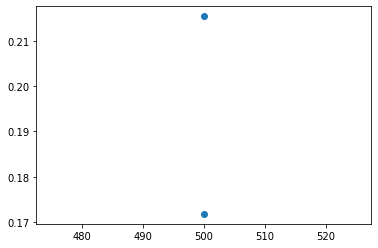

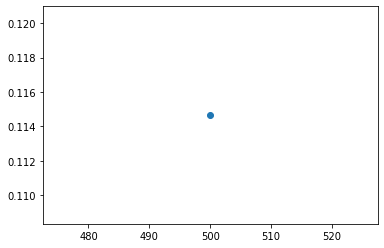

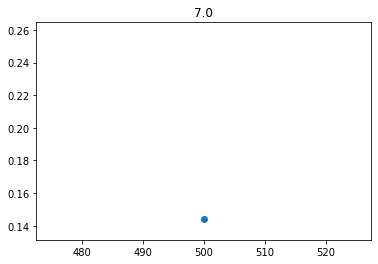

In [86]:
df = pd.read_csv(f"{CWD}/analysis/results/mcmc/rotation/mcmc_rotation_output.csv")
df = df[(df.ID==ID) & (df.tstamp == tstamp) ]
#print(df)

for s, g in df.groupby("QCS"):
    plt.figure()
    g['uperr'] = g.Prot_d_84-g.Prot_d_50
    g['loerr'] = g.Prot_d_50-g.Prot_d_16
    plt.scatter(x=g.steps, y=g.Prot_d_50)#, yerr=g[["loerr","uperr"]].values.T)
plt.plot(g.steps, g.Prot_d_LS, c="r")
plt.title(s)
plt.ylim(target.Prot_d*.995,target.Prot_d*2.005,)

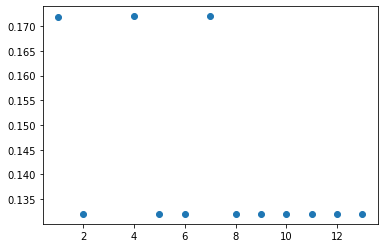

In [50]:
df2 = df[df.steps>10000]
plt.scatter(df2.QCS, df2.Prot_d_50)

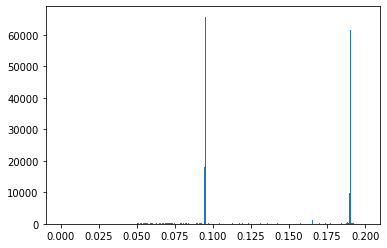

In [17]:
# truths=[phi_a, theta_a, a, fwhm,i_mu, phi0]);
plt.hist(samples.T[0], bins=np.linspace(0,.2, 300));

In [ ]:
model = cosine(time, result[1][1], 2.*np.pi/result[0][1], result[2][1],result[3][1],result[4][1])
# model = cosine(time, inits[1]*.5, 2.*np.pi/inits[0], 2.*np.pi/8.5, 0., inits[4])

5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


4
04


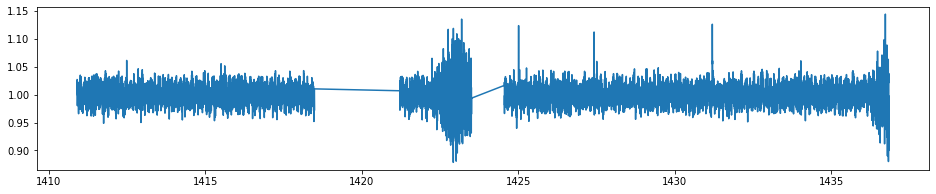

In [65]:

target.QCS = 4
print(target.QCS)
print(f"{target.QCS:02d}")

# Get light curve
flcd = fetch_lightcurve(target, flux_type="PDCSAP_FLUX")

# define flux, time and error arrays
flcd.flux[((flcd.time > target.view_start) & (flcd.time < target.view_stop))] = np.nan
flcd = flcd[np.where(np.isfinite(flcd.flux))]
flcd = flcd.flatten(window_length=1001)
time = flcd.time
flux = flcd.flux
flux_err = flcd.flux_err
plt.figure(figsize=(16,3))
plt.plot(time, flux);
#plt.plot(time, model)
# plt.xlim(1592,1594)
#plt.xlim(1429,1430)

5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


4
04


(1415.0, 1418.0)

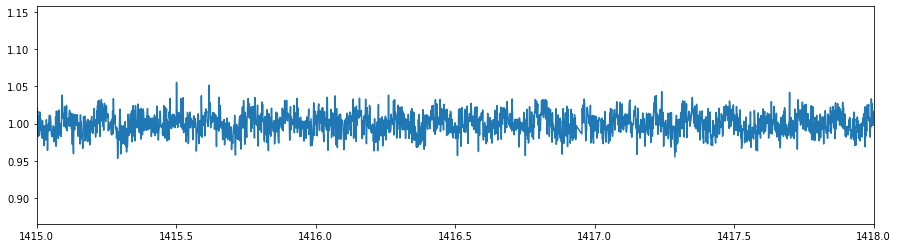

In [91]:
target.QCS = 4
print(target.QCS)
print(f"{target.QCS:02d}")

# Get light curve
flcd = fetch_lightcurve(target, flux_type="PDCSAP_FLUX")

# define flux, time and error arrays
flcd.flux[((flcd.time > target.view_start) & (flcd.time < target.view_stop))] = np.nan
flcd = flcd[np.where(np.isfinite(flcd.flux))]
flcd = flcd.flatten(window_length=1001)
time = flcd.time
flux = flcd.flux
flux_err = flcd.flux_err
plt.figure(figsize=(15,4))
plt.plot(time, flux)
#plt.plot(time, model)
# plt.xlim(1592,1594)
plt.xlim(1415,1418)

5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.168734334266055 h
TIC 300741820 modulation period:  3.168734334266055 h
TIC 300741820 modulation period:  3.168734334266055 h


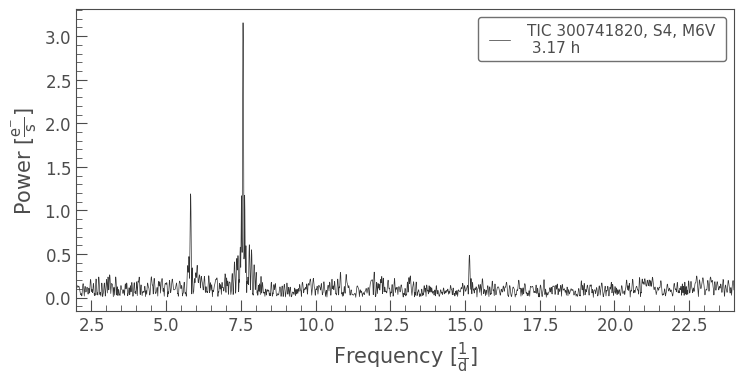

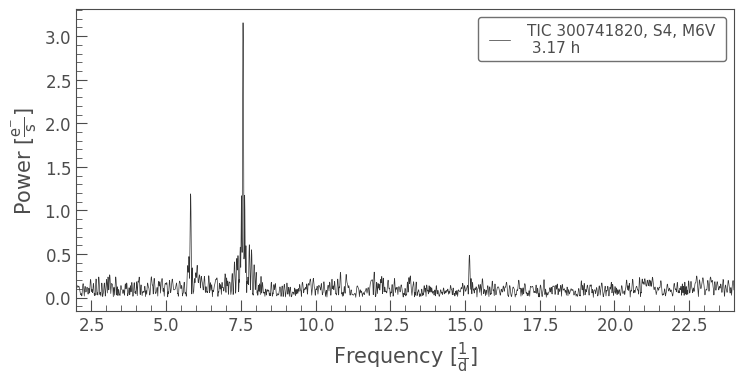

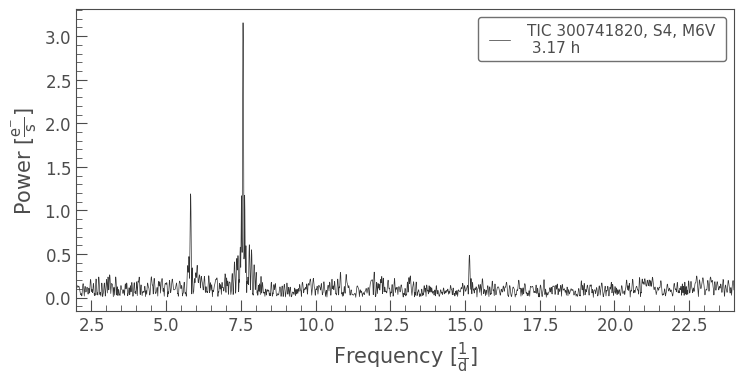

In [68]:
for QCS in [1,4,7]:
    period, mfp = find_period(target, save=False, minfreq=2, maxfreq=24, custom=True)

5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.168734334266055 h
TIC 300741820 modulation period:  3.168734334266055 h


5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.168734334266055 h
TIC 300741820 modulation period:  3.168734334266055 h


5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.168734334266055 h
TIC 300741820 modulation period:  3.168734334266055 h


5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.168734334266055 h
TIC 300741820 modulation period:  3.168734334266055 h
TIC 300741820 modulation period:  3.168734334266055 h


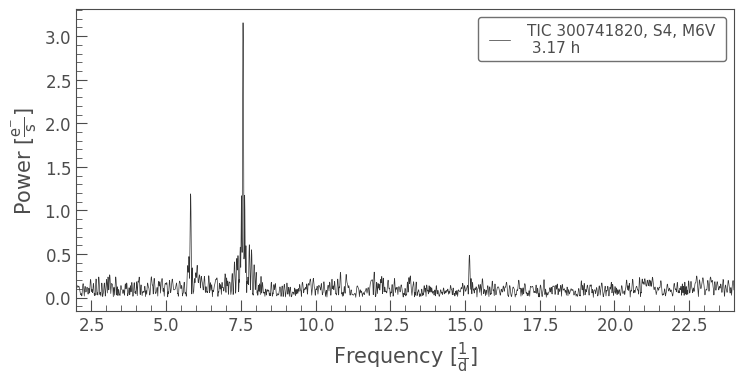

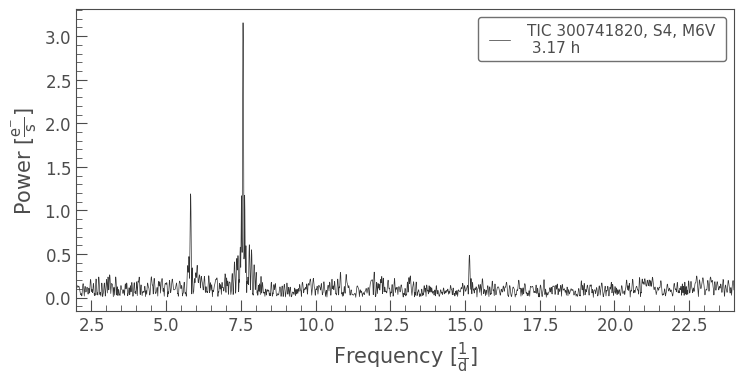

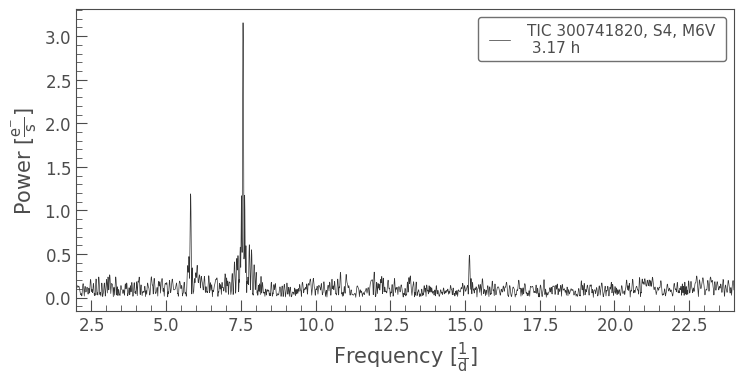

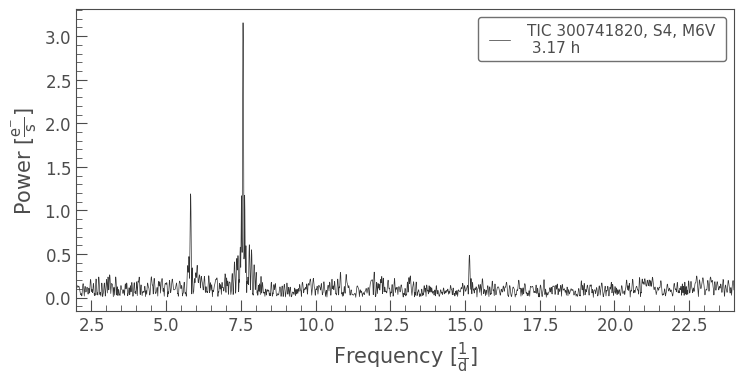

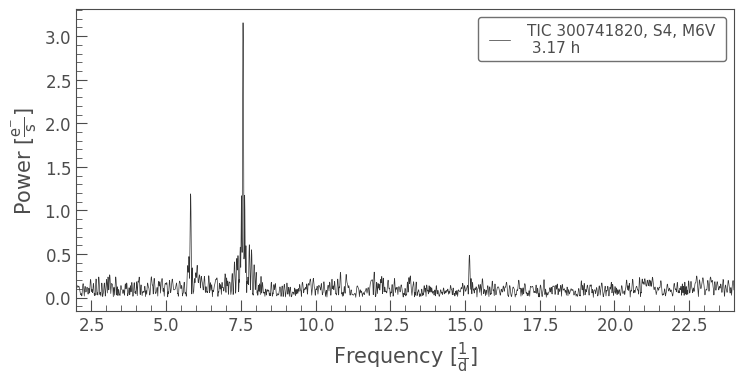

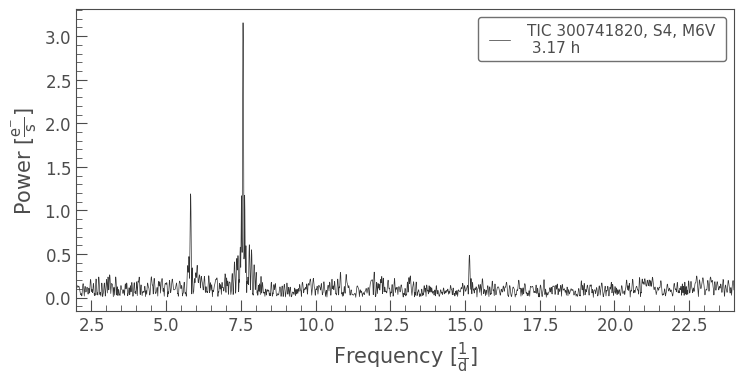

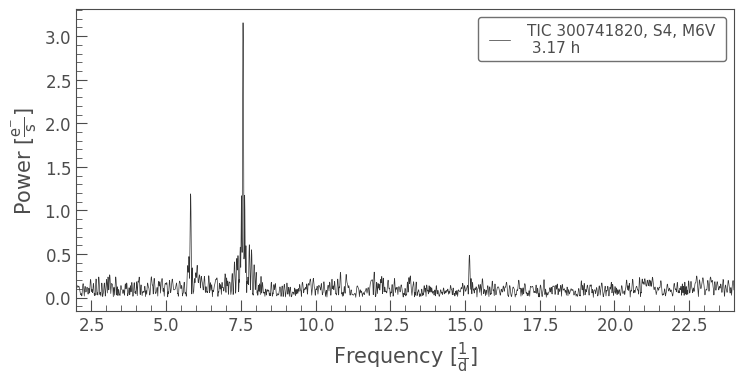

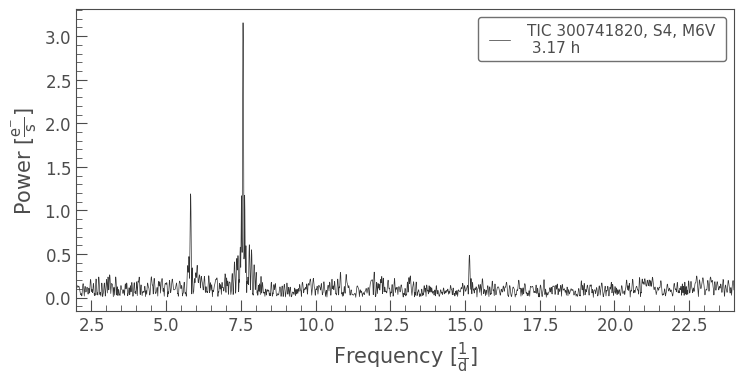

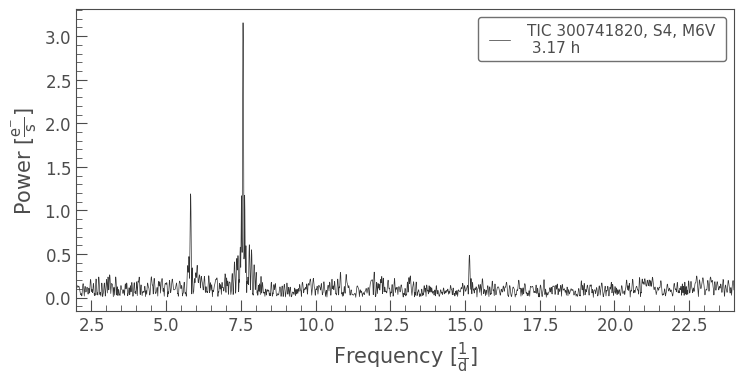

In [69]:
for QCS in [2,5,6,8,9,10,11,12,13]:
    period, mfp = find_period(target, save=False, minfreq=2, maxfreq=24, custom=True)

In [72]:
5.8/7.5

0.7733333333333333

In [80]:
3.17/24

0.13208333333333333

In [92]:
0.17182598100709*24

4.12382354417016